# Mercari Price Suggestion Challenge

## Case Study Roadmap

| Task | Status | Approval |
|------|--------|----------|
|EDA Part-I | Done | Done |
|Data Preprocessing | Done | Done |
|EDA Part-II | Done | Done |
|Feature Engineering | Done | Done |
|Feature Selection | Done | Done |
|Dataset Splitting | Done | Done |
|Feature Transformation | Done | Done |
|Modelling | Done | Done |
|Kaggle Scores | Done | Done |

## Description

<p>Product pricing gets even harder at scale, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.</p>
<p>Mercari, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.</p>
<p>In this competition, Mercari’s challenging you to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.</p>



## Objective

*   This is a regression based machine learning problem where we need to predict the price using the given input features
*   The error metric to be evaluated is RMSLE (Root Mean Square Logarithmic Error)



## Import Packages

In [5]:
import re
import nltk
import pickle
import codecs
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
tqdm_notebook().pandas()
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import SGDRegressor, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.kernel_approximation import Nystroem
from sklearn.tree import DecisionTreeRegressor
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBRegressor
from IPython.display import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Dropout, LSTM, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.backend import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from lightgbm import LGBMRegressor
from timeit import default_timer as timer

In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 133kB 2.8MB/s 


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load the Data

In [ ]:
df = pd.read_csv('train.tsv', delimiter='\t')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## EDA Part-I

In [ ]:
print("Total number of rows: ", df.shape[0])
print("Total number of columns: ", df.shape[1])

Total number of rows:  1482535
Total number of columns:  8


In [ ]:
df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


The above representation provides some valueable insights which are as follows:

*   The highest price that an item can have is 2009 USD
*   25% of the items have a price of less than 10 USD, 50% of them with less than 17 USD and 75% of all the items of less than 29 USD.
*   The item_condition_id category is basically ordinal in nature with the lowest rating being 1 and the highest rating being 5
*   The shipping category being nominal in nature has two values namely 0 and 1







In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


Following are some of the insights as obtained from the above representation:

*   Although, the total number of rows was found to be 1482535, but we can clearly see that the total number of non-null values of category_name (1476208), brand_name (849853) and item_description (1482531) are signinficantly less and hence we can conclude that the dataset has null values
*   Also the **item_condition_id** and **shipping** being categorical features, takes in integer type value





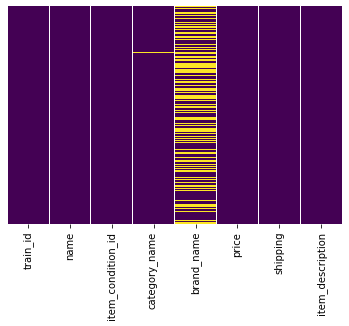

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

From the above heatmap, we can conclude that the intensity of null values is highest in case of **brand_name**, followed by **category_name**. But, since we have very less null values in case of **item_decription**, so the heatmap is not able to visualize it properly considereing the total number of rows in the dataset

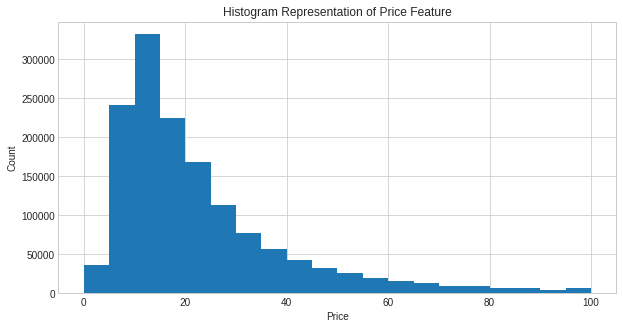

In [ ]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,5))
plt.hist(df['price'], bins=20, range=[0,100])
plt.title("Histogram Representation of Price Feature")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

From the graph, we can conlude that the distribution of **price** follows right-skewness and as per the problem statement, we need to compute the RMSLE (Root Mean Square Logarithmic Error). Hence, we need to transform the price feature to its logarithmic form

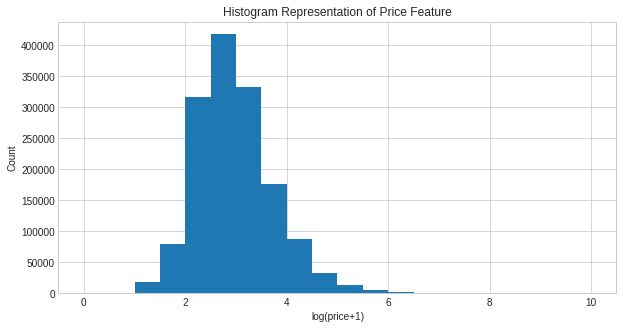

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(np.log(df['price']+1), bins=20, range=[0,10])
plt.title("Histogram Representation of Price Feature")
plt.xlabel("log(price+1)")
plt.ylabel("Count")
plt.show()

Here, we observe that the skewness of the distribution reduces once we apply log transformation. Also, we need to add a value 1 to each of the **price** feature values since the minimum price was observed to be 0 USD and log (0) is undefined

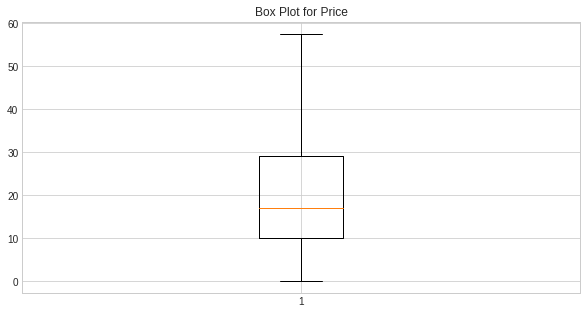

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Box Plot for Price")
plt.boxplot(df['price'], showfliers=False)
plt.show()

From the Box-Plot, we can observe that 50% of all the items lies within the range of 10 USD to 29 USD. Also majority of the items shows the enlisted price to be somewhere around 18 USD

In [ ]:
df['price'] = np.log(df['price']+1)
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity


In [ ]:
print("List of unique categories of the shipping feature: ", df['shipping'].unique())

List of unique categories of the shipping feature:  [1 0]


In [ ]:
seller_shipping = []
buyer_shipping = []
for index in tqdm_notebook(range(len(df['shipping']))):
  if df['shipping'][index] == 0:
    buyer_shipping.append(df['price'][index])
  else:
    seller_shipping.append(df['price'][index])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


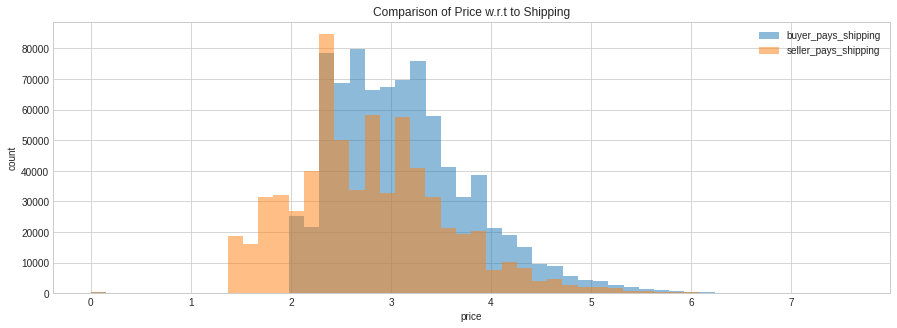

In [ ]:
#https://kite.com/python/answers/how-to-plot-two-histograms-on-one-plot-using-matplotlib-in-python
plt.figure(figsize=(15,5))
plt.hist(buyer_shipping, bins=50, alpha=0.5, label='buyer_pays_shipping')
plt.hist(seller_shipping, bins=50, alpha=0.5, label='seller_pays_shipping')
plt.xlabel('price')
plt.ylabel('count')
plt.title('Comparison of Price w.r.t to Shipping')
plt.legend()
plt.show()

From the histogram, we can conclude that if the price of the item is less, then in most cases the shipping charges is being payed by the seller and if the price is high, then in most cases the shipping charges is being payed by the buyer 

In [ ]:
print("List of unique categories of the item_condition_id feature: ", df['item_condition_id'].unique())

List of unique categories of the item_condition_id feature:  [3 1 2 4 5]


In [ ]:
grade_one = []
grade_two = []
grade_three = []
grade_four = []
grade_five = []
for index in tqdm_notebook(range(len(df['item_condition_id']))):
  if df['item_condition_id'][index] == 1:
    grade_one.append(df['price'][index])
  elif df['item_condition_id'][index] == 2:
    grade_two.append(df['price'][index])
  elif df['item_condition_id'][index] == 3:
    grade_three.append(df['price'][index])
  elif df['item_condition_id'][index] == 4:
    grade_four.append(df['price'][index])
  else:
    grade_five.append(df['price'][index])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


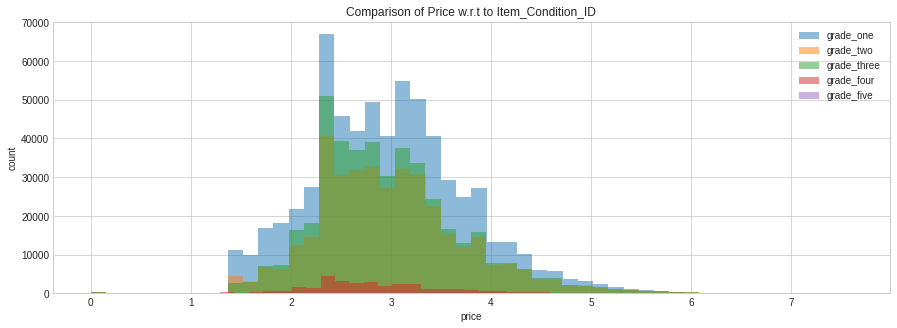

In [ ]:
plt.figure(figsize=(15,5))
plt.hist(grade_one, bins=50, alpha=0.5, label='grade_one')
plt.hist(grade_two, bins=50, alpha=0.5, label='grade_two')
plt.hist(grade_three, bins=50, alpha=0.5, label='grade_three')
plt.hist(grade_four, bins=50, alpha=0.5, label='grade_four')
plt.hist(grade_five, bins=50, alpha=0.5, label='grade_five')
plt.xlabel('price')
plt.ylabel('count')
plt.title('Comparison of Price w.r.t to Item_Condition_ID')
plt.legend()
plt.show()

From the above plot, we cannot conclude much as we can observe a lot of overlapping among the 5 categories. However, we can say that there is a high imbalance among the **item_condition_id** categories

In [ ]:
#https://stackoverflow.com/questions/50558458/pandas-percentage-by-value-in-a-column
df['item_condition_id'].value_counts(normalize=True)*100

1    43.206332
3    29.150138
2    25.326822
4     2.155902
5     0.160806
Name: item_condition_id, dtype: float64

Thus we can say that the category_1 is the most dominant with 43.2% and category_5 trails with the least at 0.2%

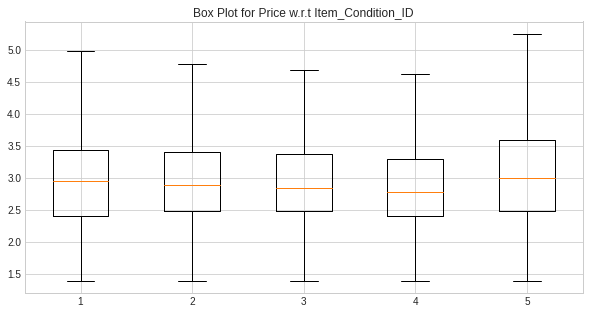

In [ ]:
_list_ = [grade_one, grade_two, grade_three, grade_four, grade_five]
plt.figure(figsize=(10,5))
plt.title("Box Plot for Price w.r.t Item_Condition_ID")
plt.boxplot(_list_, showfliers=False)
plt.show()

From the Box-Plot also, we can conclude that the 50th percentile for each of the 5 categories does not show much of a variation that can be useful to us

In [ ]:
word_cloud = WordCloud(background_color='white', max_words=100, stopwords=set(STOPWORDS))
word_cloud.generate(" ".join(df['item_description'].astype(str)))

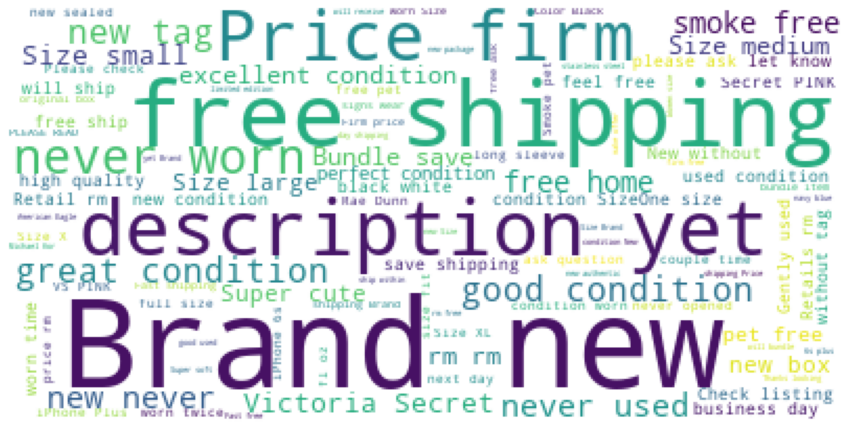

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

From the Word-Cloud plot, we can get a basic view of the 100 most frequently occuring words in the **item_desription** feature. Since the word 'Brand' is being displayed with the largest font-size, hence it occurs the most followed by words like 'new', 'free' etc.

## Data Preprocessing & EDA Part-II

### Dropping train_id

Since the train_id feature is a column comprising of unique serial numbers and hence does not hold much significance during training, so we can drop it

In [ ]:
df.drop(columns='train_id', axis=1, inplace=True)

In [ ]:
df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity


### Handling Missing Values

As observerved previously in EDA Part-I, the features **category_name**, **brand_name** and **item_description** has null values. Since all of them are of text type, the best way is to fill those missing values is with a text set as 'Missing'

In [ ]:
df['category_name'].fillna(value='Missing', inplace=True)
df['brand_name'].fillna(value='Missing', inplace=True)
df['item_description'].fillna(value='Missing', inplace=True)

In [ ]:
df.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Missing,2.397895,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Missing,3.806662,0,Complete with certificate of authenticity


In [ ]:
df.isnull().any()

name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
dtype: bool

Hence we can conclude that all the missing values have been handled

### Brand Name

In [ ]:
df['brand_name'].value_counts()

Missing              632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
                      ...  
Stampd                    1
Shout                     1
Giro                      1
Turnbull & Asser          1
OULUOQI                   1
Name: brand_name, Length: 4810, dtype: int64

Here we can observe that there are a total of 4810 unique categories of brand_name. But for our convenience, we shall try to observe the top 10 brand names with the help of a pie plot 

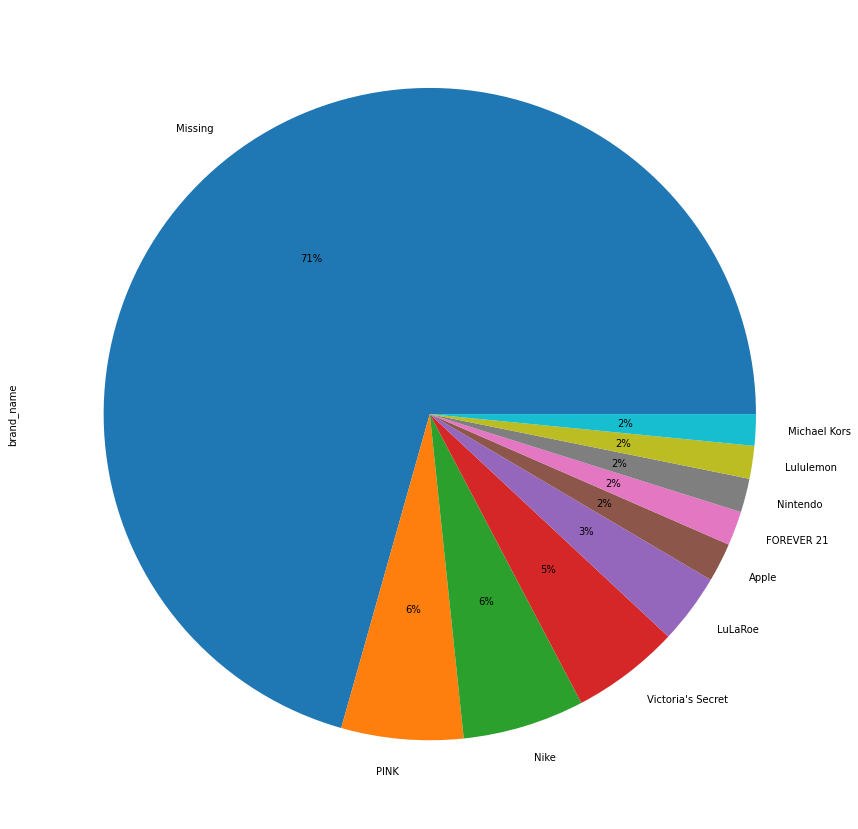

In [ ]:
# https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
df['brand_name'].value_counts()[:10].plot(kind='pie', figsize=(15, 15), autopct='%1.0f%%');

From the pie-plot, we an conclude that 71% of the data is missing for **brand_name**. However, some of the top most frequently occuring brand names are PINK(6%), Nike(6%), Victoria's Secret(5%) and LulaRoe (3%)

However, brands like PINK, Victoria's Secret and LulaRoe specializes in products designed for ladies specifically and hence we can say that the sale of female products is much higher as compared to male.

Furthermore, all three of these brands are related to the clothing line industry and hence we get the intuition that the higher sale of products is for women-wearables

### Category Name

In [ ]:
df['category_name'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Needlecraft/Clothing                         1
Handmade/Weddings/Frames                              1
Handmade/Toys/Doll Clothes                            1
Other/Automotive/RV Parts & Accessories               1
Handmade/Holidays/New Years                           1
Name: category_name, Length: 1288, dtype: int64

Looking at the data for the **category_name** feature, we observe that the forward_slash actually acts as a delimiter and so the category names can be split into a number of sub-categories. Our first task is to determine how many such sub categories are present.

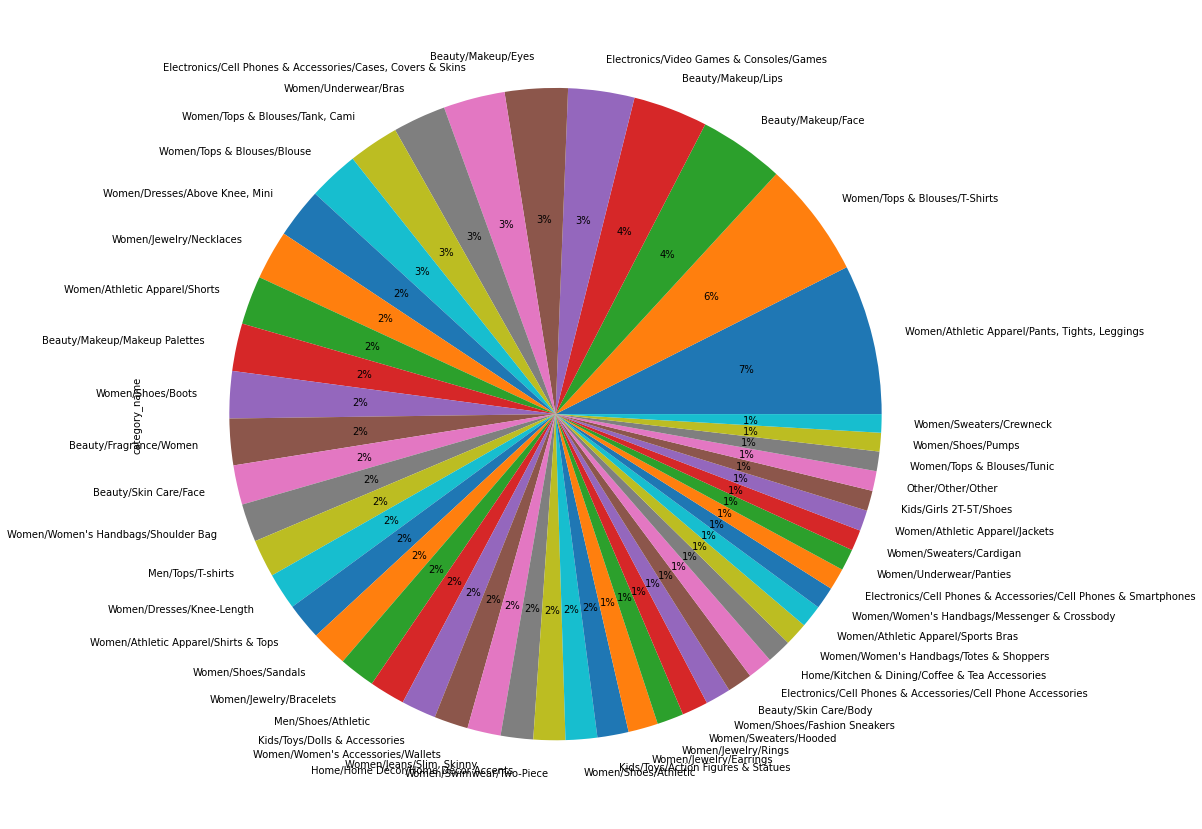

In [ ]:
# https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
df['category_name'].value_counts()[:50].plot(kind='pie', figsize=(15, 15), autopct='%1.0f%%');

From the pie-plot, we can observe that the top 50 unique category names can be split into 3 parts and so we shall consider **main_categ**, **sub_categ_one** and **sub_categ_two**

In [ ]:
def categ_split(text):
  
  '''Function to split the category into three parts'''

  if len(text.split('/')) == 1:
    return 'missing', 'missing', 'missing'
  else:    
    main_categ, sub_categ_one, sub_categ_two = text.split('/')[:3]
    return main_categ, sub_categ_one, sub_categ_two

In [ ]:
df['main_categ'], df['sub_categ_one'], df['sub_categ_two'] = zip(*df['category_name'].progress_apply(lambda x : categ_split(x)))

In [ ]:
df.drop(columns='category_name', axis=1, inplace=True)
df.head()

,name,item_condition_id,brand_name,price,shipping,item_description,main_categ,sub_categ_one,sub_categ_two
0,MLB Cincinnati Reds T Shirt Size XL,3,Missing,2.397895,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [ ]:
df['main_categ'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Missing                     6327
Name: main_categ, dtype: int64

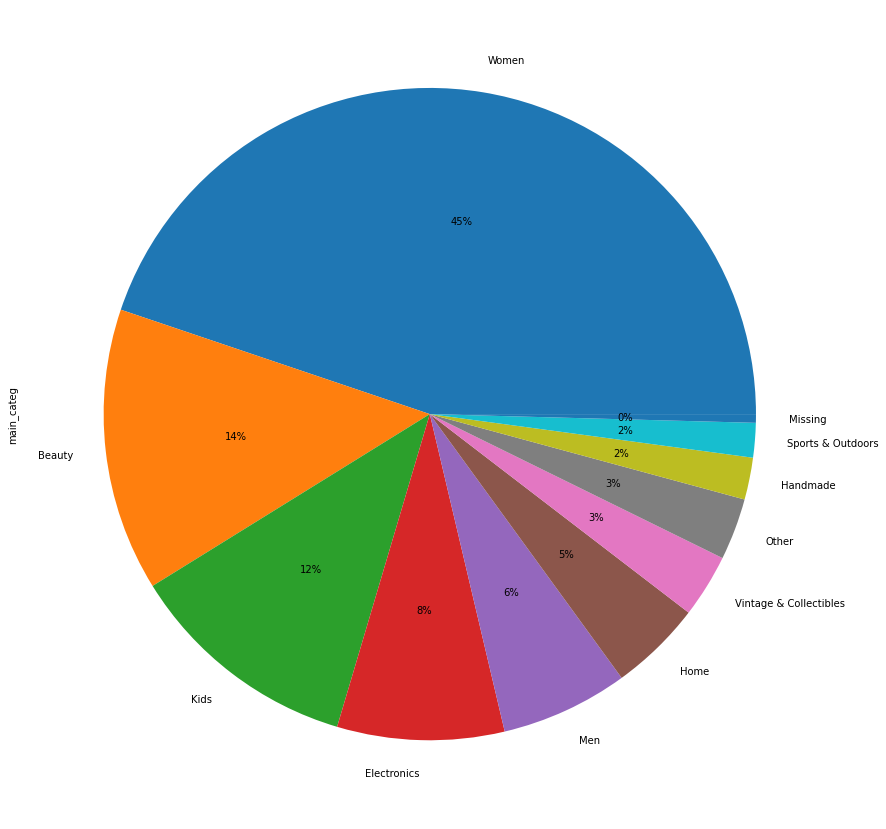

In [ ]:
# https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
df['main_categ'].value_counts().plot(kind='pie', figsize=(15, 15), autopct='%1.0f%%');

As expected from the analysis of Brand Name, we observe here that 45% of the total sale was related to Women products followed by Beauty related products which constitutes 14% of the total sales

In [ ]:
df['sub_categ_one'].value_counts()

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: sub_categ_one, Length: 114, dtype: int64

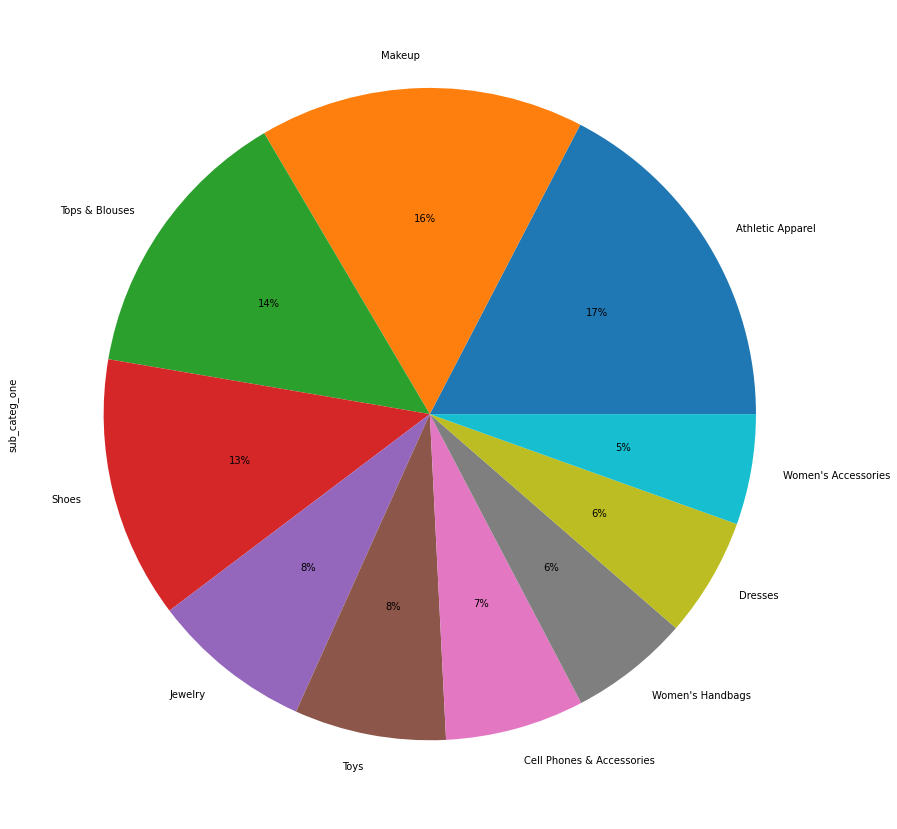

In [ ]:
# https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
df['sub_categ_one'].value_counts()[:10].plot(kind='pie', figsize=(15, 15), autopct='%1.0f%%');

Here also we observe a similar trend to women related products when considered the top 10 unique values from the **sub_categ_one** feature. However, it can be observed that apparels, cosmetics, shoes and jewelleries are the major choices for women related products 

In [ ]:
df['sub_categ_two'].value_counts()

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Pad                            1
Seasonal                       1
Cleaning                       1
Primitive                      1
Towel                          1
Name: sub_categ_two, Length: 871, dtype: int64

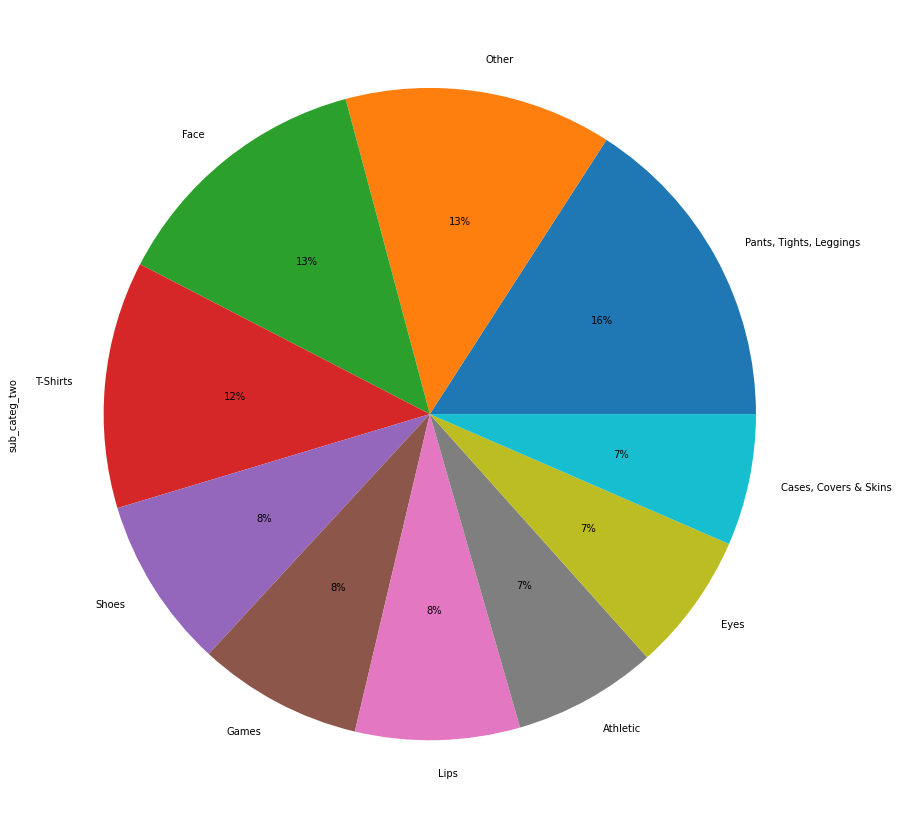

In [ ]:
# https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
df['sub_categ_two'].value_counts()[:10].plot(kind='pie', figsize=(15, 15), autopct='%1.0f%%');

The **sub_categ_two** feature gives us even a deeper clarity on the items that most of the women prefers

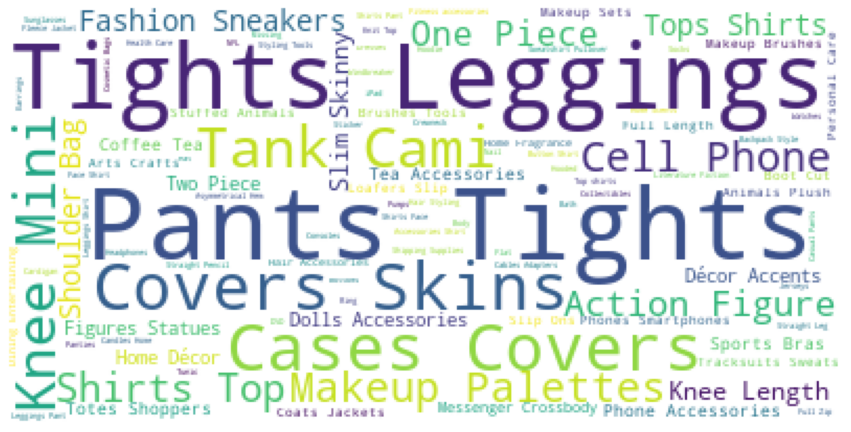

In [ ]:
word_cloud = WordCloud(background_color='white', max_words=100, stopwords=set(STOPWORDS))
word_cloud.generate(" ".join(df['sub_categ_two'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Here, if we generate a Word-Cloud plot on the sub_categ_two feature, then we can get a clearer picture of most of the frequently sold items. Also, majority of the words with bigger font-size was observed to be female-oriented, with visible words related to electronics and toys can also be observed

### Sentiment Analysis of Item Description

In [ ]:
def compute_sentiments(sentence, analyzer):

  '''Function to compute the sentiment scores'''
   
  scores_dict = analyzer.polarity_scores(sentence)
  return scores_dict['pos'], scores_dict['neg'], scores_dict['neu'], scores_dict['compound']

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
df['ss_pos'], df['ss_neg'], df['ss_neu'], df['ss_com'] = zip(*df['item_description'].progress_apply(lambda x : 
                                                                                                    compute_sentiments(x, analyzer)))

In [ ]:
df.head()

,name,item_condition_id,brand_name,price,shipping,item_description,main_categ,sub_categ_one,sub_categ_two,ss_pos,ss_neg,ss_neu,ss_com
0,MLB Cincinnati Reds T Shirt Size XL,3,Missing,2.397895,1,No description yet,Men,Tops,T-shirts,0.000,0.524,0.476,-0.2960
1,Razer BlackWidow Chroma Keyboard,3,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,0.247,0.000,0.753,0.8957
2,AVA-VIV Blouse,1,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0.171,0.000,0.829,0.6792
3,Leather Horse Statues,1,Missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0.157,0.000,0.843,0.6808
4,24K GOLD plated rose,1,Missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0.000,0.000,1.000,0.0000


### Text Preprocessing

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):

    '''Function to perform decontraction'''
    
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
eng_stopwords = stopwords.words('english')

In [ ]:
def text_preprocess(text, eng_stopwords):

  '''Function to perform text preprocessing'''

  text = decontracted(text) #Funtion to perform decontractions
  text = re.sub("[\-\\\n\t]", " ", text)  #Regex to remove all \n, \t, - and \
  text = re.sub("[^A-Za-z0-9]", " ", text)  #Regex to remove all the words except A-Za-z0-9
  text = re.sub('\s\s+', ' ', str(text))  #Regex to remove all the extra spaces
  text = text.lower() #Converts everything to lower case
  text = " ".join([word for word in text.split() if word not in eng_stopwords]) #Remove stopwords
  return text

In [ ]:
df['item_desc_preprocess'] = df['item_description'].progress_apply(lambda x : text_preprocess(x, eng_stopwords))

In [ ]:
df.drop(columns='item_description', axis=1, inplace=True)
df.head()

,name,item_condition_id,brand_name,price,shipping,main_categ,sub_categ_one,sub_categ_two,ss_pos,ss_neg,ss_neu,ss_com,item_desc_preprocess
0,MLB Cincinnati Reds T Shirt Size XL,3,Missing,2.397895,1,Men,Tops,T-shirts,0.000,0.524,0.476,-0.2960,description yet
1,Razer BlackWidow Chroma Keyboard,3,Razer,3.970292,0,Electronics,Computers & Tablets,Components & Parts,0.247,0.000,0.753,0.8957,keyboard great condition works like came box p...
2,AVA-VIV Blouse,1,Target,2.397895,1,Women,Tops & Blouses,Blouse,0.171,0.000,0.829,0.6792,adorable top hint lace key hole back pale pink...
3,Leather Horse Statues,1,Missing,3.583519,1,Home,Home Décor,Home Décor Accents,0.157,0.000,0.843,0.6808,new tags leather horses retail rm stand foot h...
4,24K GOLD plated rose,1,Missing,3.806662,0,Women,Jewelry,Necklaces,0.000,0.000,1.000,0.0000,complete certificate authenticity


In [ ]:
df['name_preprocess'] = df['name'].progress_apply(lambda x : text_preprocess(x, eng_stopwords))

In [ ]:
df.drop(columns='name', axis=1, inplace=True)
df.head()

,item_condition_id,brand_name,price,shipping,main_categ,sub_categ_one,sub_categ_two,ss_pos,ss_neg,ss_neu,ss_com,item_desc_preprocess,name_preprocess
0,3,Missing,2.397895,1,Men,Tops,T-shirts,0.000,0.524,0.476,-0.2960,description yet,mlb cincinnati reds shirt size xl
1,3,Razer,3.970292,0,Electronics,Computers & Tablets,Components & Parts,0.247,0.000,0.753,0.8957,keyboard great condition works like came box p...,razer blackwidow chroma keyboard
2,1,Target,2.397895,1,Women,Tops & Blouses,Blouse,0.171,0.000,0.829,0.6792,adorable top hint lace key hole back pale pink...,ava viv blouse
3,1,Missing,3.583519,1,Home,Home Décor,Home Décor Accents,0.157,0.000,0.843,0.6808,new tags leather horses retail rm stand foot h...,leather horse statues
4,1,Missing,3.806662,0,Women,Jewelry,Necklaces,0.000,0.000,1.000,0.0000,complete certificate authenticity,24k gold plated rose


In [ ]:
def text_length(text):

  '''Function to return the length of a text sentence'''
  
  return len(text.split())

In [ ]:
df['item_desc_length'] = df['item_desc_preprocess'].progress_apply(lambda x : text_length(x))

In [ ]:
df.head()

,item_condition_id,brand_name,price,shipping,main_categ,sub_categ_one,sub_categ_two,ss_pos,ss_neg,ss_neu,ss_com,item_desc_preprocess,name_preprocess,item_desc_length
0,3,Missing,2.397895,1,Men,Tops,T-shirts,0.000,0.524,0.476,-0.2960,description yet,mlb cincinnati reds shirt size xl,2
1,3,Razer,3.970292,0,Electronics,Computers & Tablets,Components & Parts,0.247,0.000,0.753,0.8957,keyboard great condition works like came box p...,razer blackwidow chroma keyboard,18
2,1,Target,2.397895,1,Women,Tops & Blouses,Blouse,0.171,0.000,0.829,0.6792,adorable top hint lace key hole back pale pink...,ava viv blouse,14
3,1,Missing,3.583519,1,Home,Home Décor,Home Décor Accents,0.157,0.000,0.843,0.6808,new tags leather horses retail rm stand foot h...,leather horse statues,18
4,1,Missing,3.806662,0,Women,Jewelry,Necklaces,0.000,0.000,1.000,0.0000,complete certificate authenticity,24k gold plated rose,3


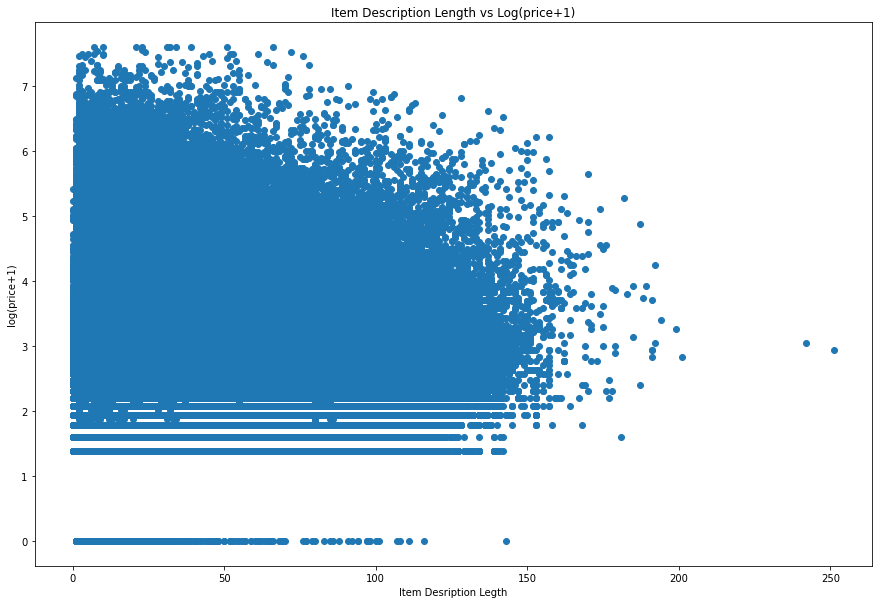

In [ ]:
plt.figure(figsize=(15,10))
x = df['item_desc_length']
y = df['price']
plt.scatter(x,y)
plt.xlabel('Item Desription Legth')
plt.ylabel('log(price+1)')
plt.title('Item Description Length vs Log(price+1)')
plt.show()

Here we observe that as the length of the item-description increases, the price seems to decrease. Thus, we can say that products with shorter desrcriptions tends to cost more.

In [ ]:
# df1 = pd.read_csv('train_preprocess.csv')

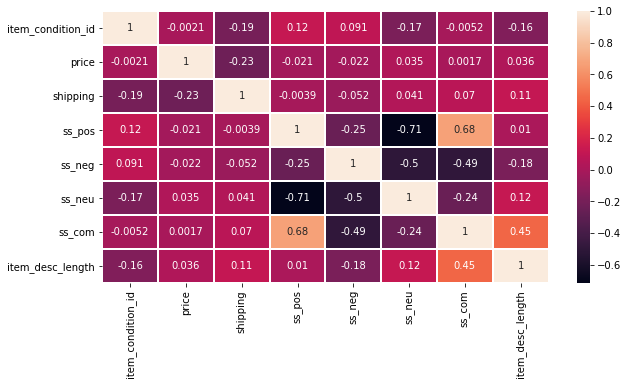

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, linewidths=1)
plt.show()

Here we observe that the **item_desc_length** feature shows a considerable amount of correlation with price and so also the sentiment scores too shows some correration with the price and hence we are going to include these features in our dataset

### Imputation of Missing Values using ML Models

Here we shall consider only one category (**main_categ**) and discard all the other sub-categories related to it and then replace all the values assigned as 'Missing' with NaN so that we can fill those missing values using KNN. We shall do the same thing for the feature **brand_name** too.

In [ ]:
def replace_missing(x):

  '''Function to replace Missing with NAN'''
  
  if x == 'Missing':
    x = np.NaN
  return x

#### Category Name

In [ ]:
df['main_categ'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Missing                     6327
Name: main_categ, dtype: int64

In [ ]:
df['main_categ'] = df['main_categ'].progress_apply(lambda x : replace_missing(x))

In [ ]:
null_dataset = df[['item_condition_id', 'price', 'shipping', 'ss_pos', 'ss_neg', 'ss_neu', 'ss_com', 'item_desc_length', 'main_categ']]
notnull_dataset = null_dataset.dropna()

X_train = notnull_dataset.iloc[:, :-1]
y_train = notnull_dataset.iloc[:, -1]

In [ ]:
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)

In [ ]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, y_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
X_test = null_dataset.iloc[:, :-1]
y_test_label = pd.Series(model.predict(X_test))

In [ ]:
y_test_label_inv = pd.Series(label_encoder.inverse_transform(y_test_label))

In [ ]:
df['category'] = df['main_categ'].fillna(y_test_label_inv) 

In [ ]:
df.drop(columns=['main_categ', 'sub_categ_one', 'sub_categ_two'], axis=1, inplace=True)
df.head()

,item_condition_id,brand_name,price,shipping,ss_pos,ss_neg,ss_neu,ss_com,item_desc_preprocess,name_preprocess,item_desc_length,category
0,3,Missing,2.397895,1,0.000,0.524,0.476,-0.2960,description yet,mlb cincinnati reds shirt size xl,2,Men
1,3,Razer,3.970292,0,0.247,0.000,0.753,0.8957,keyboard great condition works like came box p...,razer blackwidow chroma keyboard,18,Electronics
2,1,Target,2.397895,1,0.171,0.000,0.829,0.6792,adorable top hint lace key hole back pale pink...,ava viv blouse,14,Women
3,1,Missing,3.583519,1,0.157,0.000,0.843,0.6808,new tags leather horses retail rm stand foot h...,leather horse statues,18,Home
4,1,Missing,3.806662,0,0.000,0.000,1.000,0.0000,complete certificate authenticity,24k gold plated rose,3,Women


#### Brand

In [ ]:
brand_dict = dict(df['brand_name'].value_counts())

In [ ]:
brand_list = []
for key, value in brand_dict.items():
  if value < 20:
    brand_list.append(key)  

In [ ]:
def replace_brand(brand, brand_list):

  '''Function to return brand if present in brand_list'''
  
  if brand in brand_list:
    return 'Missing'
  else:
    return brand

In [ ]:
df['brand_name'] = df['brand_name'].progress_apply(lambda x : replace_brand(x, brand_list))

In [ ]:
df['brand_name'] = df['brand_name'].progress_apply(lambda x : replace_missing(x))

In [ ]:
null_dataset = df[['item_condition_id', 'price', 'shipping', 'ss_pos', 'ss_neg', 'ss_neu', 'ss_com', 'item_desc_length', 'brand_name']]
notnull_dataset = null_dataset.dropna()

X_train = notnull_dataset.iloc[:, :-1]
y_train = notnull_dataset.iloc[:, -1]

In [ ]:
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)

In [ ]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, y_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
X_test = null_dataset.iloc[:, :-1]
y_test_label = pd.Series(model.predict(X_test))

In [ ]:
y_test_label_inv = pd.Series(label_encoder.inverse_transform(y_test_label))

In [ ]:
df['brand'] = df['brand_name'].fillna(y_test_label_inv) 

In [ ]:
df.drop(columns='brand_name', axis=1, inplace=True)
df.head()

,item_condition_id,price,shipping,ss_pos,ss_neg,ss_neu,ss_com,item_desc_preprocess,name_preprocess,item_desc_length,category,brand
0,3,2.397895,1,0.000,0.524,0.476,-0.2960,description yet,mlb cincinnati reds shirt size xl,2,Men,Aeropostale
1,3,3.970292,0,0.247,0.000,0.753,0.8957,keyboard great condition works like came box p...,razer blackwidow chroma keyboard,18,Electronics,Razer
2,1,2.397895,1,0.171,0.000,0.829,0.6792,adorable top hint lace key hole back pale pink...,ava viv blouse,14,Women,Target
3,1,3.583519,1,0.157,0.000,0.843,0.6808,new tags leather horses retail rm stand foot h...,leather horse statues,18,Home,Acacia Swimwear
4,1,3.806662,0,0.000,0.000,1.000,0.0000,complete certificate authenticity,24k gold plated rose,3,Women,PINK


In [ ]:
df.isnull().sum()

item_condition_id       0
price                   0
shipping                0
ss_pos                  0
ss_neg                  0
ss_neu                  0
ss_com                  0
item_desc_preprocess    0
name_preprocess         0
item_desc_length        0
category                0
brand                   0
dtype: int64

In [ ]:
# df.to_csv('train_preprocess.csv', index=False)

In [ ]:
df = pd.read_csv('train_preprocess.csv')
df = df.replace(np.nan, '', regex=True)

### Summary of Feature Engineering
<p>Based on the above analysis, I was able to engineer some of the new features as well as modify some existing features as well. Following are some of the techniques that I used to carry out the process:</p>


*   As it was strictly mentioned in the case study objective that we need to evaluate the RMSLE, so the very first thing I did was to transform the **price** feature into it's log form. However, it was observed that the minimum price that the dataset consist of was 0 USD and so we need to add '1' before applying log over it. As such, we can now evaluate the RMSE
*   Also it was observed from many case studies that sentiment scores somestimes plays an important role if the description is present. So the sentiment scores was computed for each of the item-description thereby creating four new features **ss_pos**, **ss_neg**, **ss_neu** and **ss_com**. However, it should be kept in mind that the sentiment analysis should be performed before text-preprocessing of item-description. It is so, because if we consider an example say 'Good', then the ss_pos value of 'GOOD' is higher than that of 'good'
*   Text-preprocessing is another important step we carried out in order to modify the *name* and *item_description* feature to create the **name_preprocess** and **item_desc_preprocess** feature respectively. Here we performed decontraction, removal of alphanumeric characters as well as stopwords and also conversion to lower case which will help us to perform vectorization over it
*   Another thing I observed was that, as the length of the item-description decreases, the cost of the product seems to increase. Since we observe a fair amount of correlation between the price and length of the item-desription, so we consider **item_desc_length** as an additional feature in the dataset
*   As observed from the EDA carried out for category_name, we can assume that the three features *main_categ*, *sub_categ_one* and *sub_categ_two* are basically in a hierarchical order. Hence, the first category name can be considered as the main category and the rest of the subcategories can be said to carry less weightage. So, we discard *sub_categ_one* and *sub_categ_two* and rename the *main_categ* as **category** feature in the dataset. 
*   Also for null-value removal of categorial features namely **category** and **brand**, I took the help of model-imputation technique whereby I have used the KNN model









## Splitting the Dataset

In [ ]:
X = df[['item_condition_id', 'shipping', 'ss_pos', 'ss_neg', 'ss_neu', 'ss_com', 'item_desc_preprocess', 'name_preprocess', 
        'item_desc_length', 'category', 'brand']]
y = df[['price']]

In [ ]:
print("X.shape: ", X.shape)
print("y.shape: ", y.shape)

X.shape:  (1482535, 11)
y.shape:  (1482535, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (1037774, 11)
y_train.shape:  (1037774, 1)
X_test.shape:  (444761, 11)
y_test.shape:  (444761, 1)


## Feature Transformation

### Numerical

#### Item Desription Length

In [ ]:
minmax_scaler = MinMaxScaler()
X_train_item_desc_length = minmax_scaler.fit_transform(X_train['item_desc_length'].values.reshape(-1,1))
X_test_item_desc_length = minmax_scaler.transform(X_test['item_desc_length'].values.reshape(-1,1))

In [ ]:
print("X_train_item_desc_length: ", X_train_item_desc_length.shape)
print("X_test_item_desc_length: ", X_test_item_desc_length.shape)

X_train_item_desc_length:  (1037774, 1)
X_test_item_desc_length:  (444761, 1)


#### Positive Sentiment Score

In [ ]:
minmax_scaler = MinMaxScaler()
X_train_ss_pos = minmax_scaler.fit_transform(X_train['ss_pos'].values.reshape(-1,1))
X_test_ss_pos = minmax_scaler.transform(X_test['ss_pos'].values.reshape(-1,1))

In [ ]:
print("X_train_ss_pos: ", X_train_ss_pos.shape)
print("X_test_ss_pos: ", X_test_ss_pos.shape)

X_train_ss_pos:  (1037774, 1)
X_test_ss_pos:  (444761, 1)


#### Negative Sentiment Score

In [ ]:
minmax_scaler = MinMaxScaler()
X_train_ss_neg = minmax_scaler.fit_transform(X_train['ss_neg'].values.reshape(-1,1))
X_test_ss_neg = minmax_scaler.transform(X_test['ss_neg'].values.reshape(-1,1))

In [ ]:
print("X_train_ss_neg: ", X_train_ss_neg.shape)
print("X_test_ss_neg: ", X_test_ss_neg.shape)

X_train_ss_neg:  (1037774, 1)
X_test_ss_neg:  (444761, 1)


#### Neutral Sentiment Score

In [ ]:
minmax_scaler = MinMaxScaler()
X_train_ss_neu = minmax_scaler.fit_transform(X_train['ss_neu'].values.reshape(-1,1))
X_test_ss_neu = minmax_scaler.transform(X_test['ss_neu'].values.reshape(-1,1))

In [ ]:
print("X_train_ss_neu: ", X_train_ss_neu.shape)
print("X_test_ss_neu: ", X_test_ss_neu.shape)

X_train_ss_neu:  (1037774, 1)
X_test_ss_neu:  (444761, 1)


#### Compound Sentiment Score

In [ ]:
minmax_scaler = MinMaxScaler()
X_train_ss_com = minmax_scaler.fit_transform(X_train['ss_com'].values.reshape(-1,1))
X_test_ss_com = minmax_scaler.transform(X_test['ss_com'].values.reshape(-1,1))

In [ ]:
print("X_train_ss_com: ", X_train_ss_com.shape)
print("X_test_ss_com: ", X_test_ss_com.shape)

X_train_ss_com:  (1037774, 1)
X_test_ss_com:  (444761, 1)


### Categorical

#### Item Condition ID

In [ ]:
X_train_item_condition = np.array(pd.get_dummies(X_train['item_condition_id'], drop_first=True))
X_test_item_condition = np.array(pd.get_dummies(X_test['item_condition_id'], drop_first=True))

In [ ]:
print("X_train_item_condition: ", X_train_item_condition.shape)
print("X_test_item_condition: ", X_test_item_condition.shape)

X_train_item_condition:  (1037774, 4)
X_test_item_condition:  (444761, 4)


#### Shipping

In [ ]:
X_train_shipping = np.array(pd.get_dummies(X_train['shipping'], drop_first=True))
X_test_shipping = np.array(pd.get_dummies(X_test['shipping'], drop_first=True))

In [ ]:
print("X_train_shipping: ", X_train_shipping.shape)
print("X_test_shipping: ", X_test_shipping.shape)

X_train_shipping:  (1037774, 1)
X_test_shipping:  (444761, 1)


#### Category

In [ ]:
X_train_category = np.array(pd.get_dummies(X_train['category'], drop_first=True))
X_test_category = np.array(pd.get_dummies(X_test['category'], drop_first=True))

In [ ]:
print("X_train_category: ", X_train_category.shape)
print("X_test_category: ", X_test_category.shape)

X_train_category:  (1037774, 9)
X_test_category:  (444761, 9)


#### Brand

In [ ]:
X_train_brand = np.array(pd.get_dummies(X_train['brand'], drop_first=True))
X_test_brand = np.array(pd.get_dummies(X_test['brand'], drop_first=True))

In [ ]:
print("X_train_brand: ", X_train_brand.shape)
print("X_test_brand: ", X_test_brand.shape)

X_train_brand:  (1037774, 1279)
X_test_brand:  (444761, 1279)


### Textual

#### Name

In [ ]:
vectorizer = CountVectorizer(min_df=10, max_features=5000)
X_train_name = vectorizer.fit_transform(X_train['name_preprocess'].values)
X_test_name = vectorizer.transform(X_test['name_preprocess'].values)

In [ ]:
print("X_train_name: ", X_train_name.shape)
print("X_test_name: ", X_test_name.shape)

X_train_name:  (1037774, 5000)
X_test_name:  (444761, 5000)


#### Item Description

##### Word2Vec

In [ ]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):

    '''Function to read Glove Vectors from a text file'''

    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm_notebook(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.6B.100d.txt')

Loading Glove Model



Done. 400000  words loaded!


**NOTE:** Here we are considering Glove Model with 100 dimensions in order to overcome the limitations of computational resources. Because, I tried with 200 dimensions as well as 300 dimensions and it eventually consumes all the available 12 GB of RAM in Google Colab resulting in a crash

In [ ]:
glove_words =  set(model.keys())

In [ ]:
def w2v_vectors(preprocessed_essays, glove_words, model):

  '''Function to compute the Word2Vec'''
  
  w2v_vectors = []
  for sentence in tqdm_notebook(preprocessed_essays):
    vector = np.zeros(100)
    for word in sentence.split():
      if word in glove_words:
        vector += model[word]    
    w2v_vectors.append(vector)
  return np.array(w2v_vectors)

In [ ]:
X_train_item_desc = w2v_vectors(X_train['item_desc_preprocess'].values, glove_words, model)

In [ ]:
X_test_item_desc = w2v_vectors(X_test['item_desc_preprocess'].values, glove_words, model)

In [ ]:
print("X_train_item_desc: ", X_train_item_desc.shape)
print("X_test_item_desc: ", X_test_item_desc.shape)

X_train_item_desc:  (1037774, 100)
X_test_item_desc:  (444761, 100)


##### TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=10, max_features=5000)
X_train_item_desc_tfidf = vectorizer.fit_transform(X_train['item_desc_preprocess'].values)
X_test_item_desc_tfidf = vectorizer.transform(X_test['item_desc_preprocess'].values)

In [ ]:
print("X_train_item_desc_tfidf: ", X_train_item_desc_tfidf.shape)
print("X_test_item_desc_tfidf: ", X_test_item_desc_tfidf.shape)

X_train_item_desc_tfidf:  (1037774, 5000)
X_test_item_desc_tfidf:  (444761, 5000)


## Merging the Transformed Features

### Word2Vec

In [ ]:
X_train_merged = hstack((X_train_item_desc_length, X_train_ss_pos, X_train_ss_neg, X_train_ss_neu, X_train_ss_com, 
                         X_train_item_condition, X_train_shipping, X_train_category, X_train_brand, X_train_name, 
                         X_train_item_desc)).tocsr()
X_test_merged = hstack((X_test_item_desc_length, X_test_ss_pos, X_test_ss_neg, X_test_ss_neu, X_test_ss_com, 
                         X_test_item_condition, X_test_shipping, X_test_category, X_test_brand, X_test_name, 
                         X_test_item_desc)).tocsr()

In [ ]:
print("X_train_merged: ", X_train_merged.shape)
print("y_train: ", y_train.shape)
print("X_test_merged: ", X_test_merged.shape)
print("y_test: ", y_test.shape)

X_train_merged:  (1037774, 6398)
y_train:  (1037774, 1)
X_test_merged:  (444761, 6398)
y_test:  (444761, 1)


In [ ]:
# pickle.dump((X_train_merged, y_train, X_test_merged, y_test),open('train_test_data.pkl','wb'))

In [ ]:
X_train_merged, y_train, X_test_merged, y_test = pickle.load(open("train_test_data.pkl", 'rb'))
print("X_train_merged: ", X_train_merged.shape)
print("y_train: ", y_train.shape)
print("X_test_merged: ", X_test_merged.shape)
print("y_test: ", y_test.shape)

X_train_merged:  (1037774, 6398)
y_train:  (1037774, 1)
X_test_merged:  (444761, 6398)
y_test:  (444761, 1)


### TF-IDF

In [ ]:
X_train_merged_tfidf = hstack((X_train_item_desc_length, X_train_ss_pos, X_train_ss_neg, X_train_ss_neu, X_train_ss_com, 
                         X_train_item_condition, X_train_shipping, X_train_category, X_train_brand, X_train_name, 
                         X_train_item_desc_tfidf)).tocsr()
X_test_merged_tfidf = hstack((X_test_item_desc_length, X_test_ss_pos, X_test_ss_neg, X_test_ss_neu, X_test_ss_com, 
                         X_test_item_condition, X_test_shipping, X_test_category, X_test_brand, X_test_name, 
                         X_test_item_desc_tfidf)).tocsr()

In [ ]:
print("X_train_merged_tfidf: ", X_train_merged_tfidf.shape)
print("y_train: ", y_train.shape)
print("X_test_merged_tfidf: ", X_test_merged_tfidf.shape)
print("y_test: ", y_test.shape)

X_train_merged_tfidf:  (1037774, 11298)
y_train:  (1037774, 1)
X_test_merged_tfidf:  (444761, 11298)
y_test:  (444761, 1)


In [ ]:
# pickle.dump((X_train_merged_tfidf, y_train, X_test_merged_tfidf, y_test),open('train_test_data_tfidf.pkl','wb'))

In [ ]:
X_train_merged_tfidf, y_train, X_test_merged_tfidf, y_test = pickle.load(open("train_test_data_tfidf.pkl", 'rb'))
print("X_train_merged_tfidf: ", X_train_merged_tfidf.shape)
print("y_train: ", y_train.shape)
print("X_test_merged_tfidf: ", X_test_merged_tfidf.shape)
print("y_test: ", y_test.shape)

X_train_merged_tfidf:  (1037774, 11298)
y_train:  (1037774, 1)
X_test_merged_tfidf:  (444761, 11298)
y_test:  (444761, 1)


## Model Building

### Linear Regression

#### Word2Vec

In [ ]:
alpha = [0.0001, 0.001, 0.01, 0.1, 1]
model_list = []
rmsle_list = []
for i in alpha:
  sgd_reg = SGDRegressor(loss='squared_loss', alpha=i)
  sgd_reg.fit(X_train_merged, y_train)
  y_pred = sgd_reg.predict(X_test_merged)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(sgd_reg)
  rmsle_list.append(rmsle)
  print("alpha: ", i, "; rmsle: ", rmsle)

alpha:  0.0001 ; rmsle:  159138104034.09943
alpha:  0.001 ; rmsle:  322085205838.11884
alpha:  0.01 ; rmsle:  107623308630.36296
alpha:  0.1 ; rmsle:  629953798387.201
alpha:  1 ; rmsle:  382824428787.546


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Linear Regression: ", rmsle_list[index])

RMSLE for Linear Regression:  107623308630.36296


In [ ]:
# best_model = model_list[index]
# pickle.dump((best_model), open('lin_reg_model.pkl', 'wb'))

#### TF-IDF

In [ ]:
alpha = [0.0001, 0.001, 0.01, 0.1, 1]
model_list = []
rmsle_list = []
for i in alpha:
  sgd_reg = SGDRegressor(loss='squared_loss', alpha=i)
  sgd_reg.fit(X_train_merged_tfidf, y_train)
  y_pred = sgd_reg.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(sgd_reg)
  rmsle_list.append(rmsle)
  print("alpha: ", i, "; rmsle: ", rmsle)

alpha:  0.0001 ; rmsle:  0.4991097776348212
alpha:  0.001 ; rmsle:  0.5298565953603486
alpha:  0.01 ; rmsle:  0.6229835578741366
alpha:  0.1 ; rmsle:  0.692492837334803
alpha:  1 ; rmsle:  0.7357990581454967


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Linear Regression: ", rmsle_list[index])

RMSLE for Linear Regression:  0.4991097776348212


In [ ]:
# best_model = model_list[index]
# pickle.dump((best_model), open('lin_reg_model_tfidf.pkl', 'wb'))

### SVM

#### Word2Vec

In [ ]:
alpha = [0.0001, 0.001, 0.01, 0.1, 1]
model_list = []
rmsle_list = []
for i in alpha:
  sgd_reg = SGDRegressor(loss='epsilon_insensitive', alpha=i)
  sgd_reg.fit(X_train_merged, y_train)
  y_pred = sgd_reg.predict(X_test_merged)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(sgd_reg)
  rmsle_list.append(rmsle)
  print("alpha: ", i, "; rmsle: ", rmsle)

alpha:  0.0001 ; rmsle:  0.8744505074650256
alpha:  0.001 ; rmsle:  1.7903768299276508
alpha:  0.01 ; rmsle:  0.738126529776633
alpha:  0.1 ; rmsle:  1.2594065090689817
alpha:  1 ; rmsle:  0.7817936780647404


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for SVM: ", rmsle_list[index])

RMSLE for SVM:  0.738126529776633


In [ ]:
# best_model = model_list[index]
# pickle.dump((best_model), open('svm_model.pkl', 'wb'))

#### TF-IDF

In [ ]:
alpha = [0.0001, 0.001, 0.01, 0.1, 1]
model_list = []
rmsle_list = []
for i in alpha:
  sgd_reg = SGDRegressor(loss='epsilon_insensitive', alpha=i)
  sgd_reg.fit(X_train_merged_tfidf, y_train)
  y_pred = sgd_reg.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(sgd_reg)
  rmsle_list.append(rmsle)
  print("alpha: ", i, "; rmsle: ", rmsle)

alpha:  0.0001 ; rmsle:  0.49861784388924685
alpha:  0.001 ; rmsle:  0.528407301472806
alpha:  0.01 ; rmsle:  0.6185025045890656
alpha:  0.1 ; rmsle:  0.6925374640760236
alpha:  1 ; rmsle:  0.7397948457505384


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for SVM: ", rmsle_list[index])

RMSLE for SVM:  0.49861784388924685


In [ ]:
# best_model = model_list[index]
# pickle.dump((best_model), open('svm_model_tfidf.pkl', 'wb'))

### XGBoost

#### Word2Vec

In [ ]:
n = 100000
indices = np.random.choice(X_train_merged.shape[0], n, replace=False)
X_train_merged_subset = X_train_merged[indices]
y_train_subset = y_train.iloc[indices]

In [ ]:
print("X_train_merged_subset: ", X_train_merged_subset.shape)
print("y_train_subset: ", y_train_subset.shape)

X_train_merged_subset:  (100000, 6398)
y_train_subset:  (100000, 1)


**NOTE:**  Due to limitations in computational resoures, I have generated a random sample of 100,000 points from the train_dataset and used it to train the xgboost and  random_forest model.

In [ ]:
n_estimators = [100, 150]
max_depth = [5, 15, 25, 35]
model_list = []
rmsle_list = []
for i in n_estimators:
  for j in max_depth:
    #WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    xgboost = XGBRegressor(max_depth=j, n_estimators=i, n_jobs=-1, objective='reg:squarederror')
    xgboost.fit(X_train_merged_subset, y_train_subset)
    y_pred = xgboost.predict(X_test_merged)
    rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
    model_list.append(xgboost)
    rmsle_list.append(rmsle)
    print("n_estimators: ", i, "; max_depth: ", j, "; rmsle: ", rmsle)

n_estimators:  100 ; max_depth:  5 ; rmsle:  0.6073066331280245
n_estimators:  100 ; max_depth:  15 ; rmsle:  0.556277267952677
n_estimators:  100 ; max_depth:  25 ; rmsle:  0.5530092999546444
n_estimators:  100 ; max_depth:  35 ; rmsle:  0.5612207299216088
n_estimators:  150 ; max_depth:  5 ; rmsle:  0.591311250016855
n_estimators:  150 ; max_depth:  15 ; rmsle:  0.5447924928285303
n_estimators:  150 ; max_depth:  25 ; rmsle:  0.5463610223771576
n_estimators:  150 ; max_depth:  35 ; rmsle:  0.5569451637570476


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for XGBoost: ", rmsle_list[index])

RMSLE for XGBoost:  0.5447924928285303


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('xgboost_model.pkl', 'wb'))

#### TF-IDF

In [ ]:
n_estimators = [100, 150]
max_depth = [5, 15, 25, 35]
model_list = []
rmsle_list = []
for i in n_estimators:
  for j in max_depth:
    #WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    xgboost = XGBRegressor(max_depth=j, n_estimators=i, n_jobs=-1, objective='reg:squarederror')
    xgboost.fit(X_train_merged_tfidf, y_train)
    y_pred = xgboost.predict(X_test_merged_tfidf)
    rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
    model_list.append(xgboost)
    rmsle_list.append(rmsle)
    print("n_estimators: ", i, "; max_depth: ", j, "; rmsle: ", rmsle)

n_estimators:  100 ; max_depth:  5 ; rmsle:  0.5943356743891247
n_estimators:  100 ; max_depth:  15 ; rmsle:  0.5169221922200571
n_estimators:  100 ; max_depth:  25 ; rmsle:  0.4875132291458047
n_estimators:  100 ; max_depth:  35 ; rmsle:  0.47428537631715095
n_estimators:  150 ; max_depth:  5 ; rmsle:  0.5763477847173661
n_estimators:  150 ; max_depth:  15 ; rmsle:  0.5012157074094887
n_estimators:  150 ; max_depth:  25 ; rmsle:  0.4753704435899721
n_estimators:  150 ; max_depth:  35 ; rmsle:  0.46478922048855653


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for XGBoost: ", rmsle_list[index])

RMSLE for XGBoost:  0.46478922048855653


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('xgboost_model_tfidf.pkl', 'wb'))

### Random Forest

#### Word2Vec

In [ ]:
max_depth = [5, 15, 25, 35]
model_list = []
rmsle_list = []
for i in max_depth:
  random_forest = RandomForestRegressor(max_depth=i, n_jobs=-1)
  random_forest.fit(X_train_merged_subset, y_train_subset)
  y_pred = random_forest.predict(X_test_merged)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(random_forest)
  rmsle_list.append(rmsle)
  print("max_depth: ", i, "; rmsle: ", rmsle)

max_depth:  5 ; rmsle:  0.6902736295480992
max_depth:  15 ; rmsle:  0.6372027008123218
max_depth:  25 ; rmsle:  0.607237615439859
max_depth:  35 ; rmsle:  0.5920548346130637


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Random Forest: ", rmsle_list[index])

RMSLE for Random Forest:  0.5920548346130637


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('random_forest_model.pkl', 'wb'))

**NOTE:** It has been observed that the error dereases with the increase in the max-depth parameter. So, as extension to this model we can conclude that if we increase the max-depth, then chances are that we might be able to implove the error value

#### TF-IDF

In [ ]:
n = 100000
indices = np.random.choice(X_train_merged_tfidf.shape[0], n, replace=False)
X_train_merged_subset_tfidf = X_train_merged_tfidf[indices]
y_train_subset_tfidf = y_train.iloc[indices]

In [ ]:
print("X_train_merged_subset_tfidf: ", X_train_merged_subset_tfidf.shape)
print("y_train_subset_tfidf: ", y_train_subset_tfidf.shape)

X_train_merged_subset_tfidf:  (100000, 11298)
y_train_subset_tfidf:  (100000, 1)


In [ ]:
max_depth = [5, 15, 25, 35]
model_list = []
rmsle_list = []
for i in max_depth:
  random_forest = RandomForestRegressor(max_depth=i, n_jobs=-1)
  random_forest.fit(X_train_merged_subset_tfidf, y_train_subset_tfidf)
  y_pred = random_forest.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(random_forest)
  rmsle_list.append(rmsle)
  print("max_depth: ", i, "; rmsle: ", rmsle)

max_depth:  5 ; rmsle:  0.6887518217836993
max_depth:  15 ; rmsle:  0.6356740147474559
max_depth:  25 ; rmsle:  0.6063874540246387
max_depth:  35 ; rmsle:  0.5877020211555425


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Random Forest: ", rmsle_list[index])

RMSLE for Random Forest:  0.5877020211555425


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('random_forest_model_tfidf.pkl', 'wb'))

### Decision Tree

#### Word2Vec

In [ ]:
max_depth = [5, 15, 25, 35, 45, 55, 65, 75]
min_samples_split = [0.1, 0.5, 1.0]
model_list = []
rmsle_list = []
for i in max_depth:
  for j in min_samples_split:    
    decision_tree = DecisionTreeRegressor(max_depth=i, min_samples_split=j)
    decision_tree.fit(X_train_merged, y_train)
    y_pred = decision_tree.predict(X_test_merged)
    rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
    model_list.append(decision_tree)
    rmsle_list.append(rmsle)
    print("max_depth: ", i, "; min_samples_split: ", j, "; rmsle: ", rmsle)

max_depth:  5 ; min_samples_split:  0.1 ; rmsle:  0.6982829761235219
max_depth:  5 ; min_samples_split:  0.5 ; rmsle:  0.7263525154777465
max_depth:  5 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456126
max_depth:  15 ; min_samples_split:  0.1 ; rmsle:  0.6688286065729966
max_depth:  15 ; min_samples_split:  0.5 ; rmsle:  0.7263525154777465
max_depth:  15 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456126
max_depth:  25 ; min_samples_split:  0.1 ; rmsle:  0.6637461731981418
max_depth:  25 ; min_samples_split:  0.5 ; rmsle:  0.7263525154777465
max_depth:  25 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456126
max_depth:  35 ; min_samples_split:  0.1 ; rmsle:  0.6619457526296816
max_depth:  35 ; min_samples_split:  0.5 ; rmsle:  0.7263525154777465
max_depth:  35 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456123
max_depth:  45 ; min_samples_split:  0.1 ; rmsle:  0.6614672874557554
max_depth:  45 ; min_samples_split:  0.5 ; rmsle:  0.7263525154777465
max_depth:  45 ; min_sa

In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Decision Tree: ", rmsle_list[index])

RMSLE for Decision Tree:  0.6614672874557554


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('decision_tree_model.pkl', 'wb'))

**NOTE:** Here we have observed that of all the two hyperparameters that we have considered, tuning max-depth improves the error value as compared to min-samples-split

#### TF-IDF

In [ ]:
max_depth = [5, 15, 25, 35, 45, 55, 65, 75]
min_samples_split = [0.1, 0.5, 1.0]
model_list = []
rmsle_list = []
for i in max_depth:
  for j in min_samples_split:    
    decision_tree = DecisionTreeRegressor(max_depth=i, min_samples_split=j)
    decision_tree.fit(X_train_merged_tfidf, y_train)
    y_pred = decision_tree.predict(X_test_merged_tfidf)
    rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
    model_list.append(decision_tree)
    rmsle_list.append(rmsle)
    print("max_depth: ", i, "; min_samples_split: ", j, "; rmsle: ", rmsle)

max_depth:  5 ; min_samples_split:  0.1 ; rmsle:  0.6978254295737899
max_depth:  5 ; min_samples_split:  0.5 ; rmsle:  0.7189026975713293
max_depth:  5 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456123
max_depth:  15 ; min_samples_split:  0.1 ; rmsle:  0.662579156585129
max_depth:  15 ; min_samples_split:  0.5 ; rmsle:  0.7189026975713292
max_depth:  15 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456122
max_depth:  25 ; min_samples_split:  0.1 ; rmsle:  0.6488026284131979
max_depth:  25 ; min_samples_split:  0.5 ; rmsle:  0.7189026975713292
max_depth:  25 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456122
max_depth:  35 ; min_samples_split:  0.1 ; rmsle:  0.6456642259530102
max_depth:  35 ; min_samples_split:  0.5 ; rmsle:  0.7189026975713292
max_depth:  35 ; min_samples_split:  1.0 ; rmsle:  0.7301744461456123
max_depth:  45 ; min_samples_split:  0.1 ; rmsle:  0.6456642259530099
max_depth:  45 ; min_samples_split:  0.5 ; rmsle:  0.7189026975713292
max_depth:  45 ; min_sam

In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Decision Tree: ", rmsle_list[index])

RMSLE for Decision Tree:  0.6456642259530098


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('decision_tree_model_tfidf.pkl', 'wb'))

### LSTM+CNN

#### Textual

In [ ]:
X_train_essay = X_train['item_desc_preprocess']
X_test_essay = X_test['item_desc_preprocess']

In [ ]:
vectorizer = TfidfVectorizer(min_df=1)
X_train_essay_vect = vectorizer.fit_transform(X_train_essay)
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))

In [ ]:
print(np.percentile(idf, np.arange(0, 100, 25)))

[ 2.17110916 12.90667941 14.15944238 14.15944238]


In [ ]:
percentile_25 = 12.90667941
percentile_75 = 14.15944238
print("25th Percentile: ", percentile_25)
print("75th Percentile: ", percentile_75)

25th Percentile:  12.90667941
75th Percentile:  14.15944238


In [ ]:
X_train_essay_tfidf = []
for key in tqdm_notebook(idf_dict):
  value = idf_dict.get(key)
  if value>=percentile_25 and value<=percentile_75:
    X_train_essay_tfidf.append(key)

**NOTE:** Here, we are removing the low idf value and high idf value words from our data because very frequent words and very very rare words don't give much information. As such we shall be considering only those within the 50 percentile range.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_essay_tfidf)
X_train_sequences = tokenizer.texts_to_sequences(X_train_essay)
X_test_sequences = tokenizer.texts_to_sequences(X_test_essay)

In [ ]:
word_index_essay = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index_essay))

Found 97969 unique tokens.


In [ ]:
def compute_max_length(sequences):

  '''Function to compute the max_length'''
  
  seq_count = []
  for element in sequences:
    length = len(element)
    seq_count.append(length)

  max_length = max(seq_count)  
  return max_length  

In [ ]:
train_essay_max_length = compute_max_length(X_train_sequences)
print("Max-Length for X_train sequences: ", train_essay_max_length)
test_essay_max_length = compute_max_length(X_test_sequences)
print("Max-Length for X_test sequences: ", test_essay_max_length)

Max-Length for X_train sequences:  135
Max-Length for X_test sequences:  39


In [ ]:
max_length_essay = int(np.round(np.average([train_essay_max_length, test_essay_max_length])))
print("Max-Length to consider: ", max_length_essay)

Max-Length to consider:  87


In [ ]:
X_train_essay_seq = pad_sequences(X_train_sequences, maxlen=max_length_essay)
X_test_essay_seq = pad_sequences(X_test_sequences, maxlen=max_length_essay)

In [ ]:
print(X_train_essay_seq.shape)
print(X_test_essay_seq.shape)

(1037774, 87)
(444761, 87)


In [ ]:
glove_vectors = {}
with codecs.open('glove.6B.100d.txt', 'r', encoding='utf-8', errors='ignore') as text_file:
  for line in tqdm_notebook(text_file):
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove_vectors[word] = vector
  text_file.close()
print("Number of word vectors: ", len(glove_vectors))


Number of word vectors:  400000


In [ ]:
#len(word_index)+1 ::: Invalid argument:  indices[22,8741] = 118909 is not in [0, 118909)
embed_matrix_essay = np.zeros((len(word_index_essay)+1, 100))
for word, index in tqdm_notebook(word_index_essay.items()):
  embed_vector = glove_vectors.get(word)
  if embed_vector is not None:
    embed_matrix_essay[index] = embed_vector

In [ ]:
print("Shape of the embed_matrix: ", embed_matrix_essay.shape)

Shape of the embed_matrix:  (97970, 100)


#### Categorical

##### Category

In [ ]:
X_train_cat = X_train['category']
X_test_cat = X_test['category']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_cat)
X_train_sequences = tokenizer.texts_to_sequences(X_train_cat)
X_test_sequences = tokenizer.texts_to_sequences(X_test_cat)

In [ ]:
word_index_category = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index_category))

Found 12 unique tokens.


In [ ]:
train_category_max_length = compute_max_length(X_train_sequences)
print("Max-Length for X_train sequences: ", train_category_max_length)
test_category_max_length = compute_max_length(X_test_sequences)
print("Max-Length for X_test sequences: ", test_category_max_length)

Max-Length for X_train sequences:  2
Max-Length for X_test sequences:  2


In [ ]:
max_length_category = 2
print("Max-Length to consider: ", max_length_category)

Max-Length to consider:  2


In [ ]:
X_train_category_seq = pad_sequences(X_train_sequences, maxlen=max_length_category)
X_test_category_seq = pad_sequences(X_test_sequences, maxlen=max_length_category)

In [ ]:
print(X_train_category_seq.shape)
print(X_train_category_seq.shape)

(1037774, 2)
(1037774, 2)


##### Brand

In [ ]:
X_train_cat = X_train['brand']
X_test_cat = X_test['brand']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_cat)
X_train_sequences = tokenizer.texts_to_sequences(X_train_cat)
X_test_sequences = tokenizer.texts_to_sequences(X_test_cat)

In [ ]:
word_index_brand = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index_brand))

Found 1598 unique tokens.


In [ ]:
train_brand_max_length = compute_max_length(X_train_sequences)
print("Max-Length for X_train sequences: ", train_brand_max_length)
test_brand_max_length = compute_max_length(X_test_sequences)
print("Max-Length for X_test sequences: ", test_brand_max_length)

Max-Length for X_train sequences:  5
Max-Length for X_test sequences:  5


In [ ]:
max_length_brand = 5
print("Max-Length to consider: ", max_length_brand)

Max-Length to consider:  5


In [ ]:
X_train_brand_seq = pad_sequences(X_train_sequences, maxlen=max_length_brand)
X_test_brand_seq = pad_sequences(X_test_sequences, maxlen=max_length_brand)

In [ ]:
print(X_train_brand_seq.shape)
print(X_test_brand_seq.shape)

(1037774, 5)
(444761, 5)


#### Numerical

In [ ]:
X_train_numeric = np.hstack((X_train_item_desc_length, X_train_ss_pos, X_train_ss_neg, X_train_ss_neu, 
                             X_train_ss_com, X_train_item_condition, X_train_shipping))
X_test_numeric = np.hstack((X_test_item_desc_length, X_test_ss_pos, X_test_ss_neg, X_test_ss_neu, 
                            X_test_ss_com, X_test_item_condition, X_test_shipping))

In [ ]:
print('Shape of X_train_numeric:', X_train_numeric.shape)
print('Shape of X_test_numeric:', X_test_numeric.shape)

Shape of X_train_numeric: (1037774, 10)
Shape of X_test_numeric: (444761, 10)


In [ ]:
max_length_numeric = 10
print("Max-Length to consider: ", max_length_numeric)

Max-Length to consider:  10


#### Model Architecture

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
#item_description
input_seq_total_text_data = Input(shape=(max_length_essay,), dtype='int32', name="input_seq_total_text_data")
emb_text_data = Embedding(len(word_index_essay)+1, 100, weights=[embed_matrix_essay], 
                        input_length=max_length_essay, trainable=False, name="emb_text_data")(input_seq_total_text_data)
lstm = LSTM(64, activation='relu', kernel_initializer='he_normal', return_sequences=True, name='lstm')(emb_text_data)
conv1d_1 = Conv1D(16, 3, activation='relu', kernel_initializer='he_normal', name='conv1d_1')(lstm)
flatten_1 = Flatten(name='flatten_1')(conv1d_1)

#category
input_category = Input(shape=(max_length_category,), dtype='int32', name="input_category")
emb_category = Embedding(len(word_index_category)+1, 10, input_length=max_length_category, 
                                 name='emb_category')(input_category)
flatten_2 = Flatten(name='flatten_2')(emb_category)

#brand
input_brand = Input(shape=(max_length_brand,), dtype='int32', name="input_brand")
emb_brand = Embedding(len(word_index_brand)+1, 10, input_length=max_length_brand, 
                                 name='emb_brand')(input_brand)
flatten_3 = Flatten(name='flatten_3')(emb_brand)

#numeric
input_remaining = Input(shape=(max_length_numeric,), dtype='float32', name="input_remaining")
dense_for_rem_input = Dense(units=32, activation='relu', kernel_initializer='he_normal', name='dense_for_rem_input')(input_remaining)

concatenate = concatenate([flatten_1, flatten_2, flatten_3, dense_for_rem_input])
dense_layer_1_after_concat = Dense(units=32, activation='relu', kernel_initializer='he_normal', 
                                   name='dense_layer_1_after_concat')(concatenate)
dropout = Dropout(rate=0.8, name='dropout')(dense_layer_1_after_concat)
dense_layer_2_after_concat = Dense(units=32, activation='relu', kernel_initializer='he_normal', 
                                   name='dense_layer_2_after_concat')(dropout)
dropout_1 = Dropout(rate=0.8, name='dropout_1')(dense_layer_2_after_concat)
dense_layer_after_concat = Dense(units=32, activation='relu', kernel_initializer='he_normal', 
                                 name='dense_layer_after_concat')(dropout_1)
output_layer = Dense(units=1, activation='linear', name='output_layer')(dense_layer_after_concat)

In [ ]:
nn_model_1 = Model(inputs=[input_seq_total_text_data, input_category, input_brand, input_remaining], outputs=output_layer)

In [ ]:
nn_model_1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='mean_squared_error')

In [ ]:
nn_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data (Inpu [(None, 87)]         0                                            
__________________________________________________________________________________________________
emb_text_data (Embedding)       (None, 87, 100)      9797000     input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 87, 64)       42240       emb_text_data[0][0]              
__________________________________________________________________________________________________
input_category (InputLayer)     [(None, 2)]          0                                            
______________________________________________________________________________________________

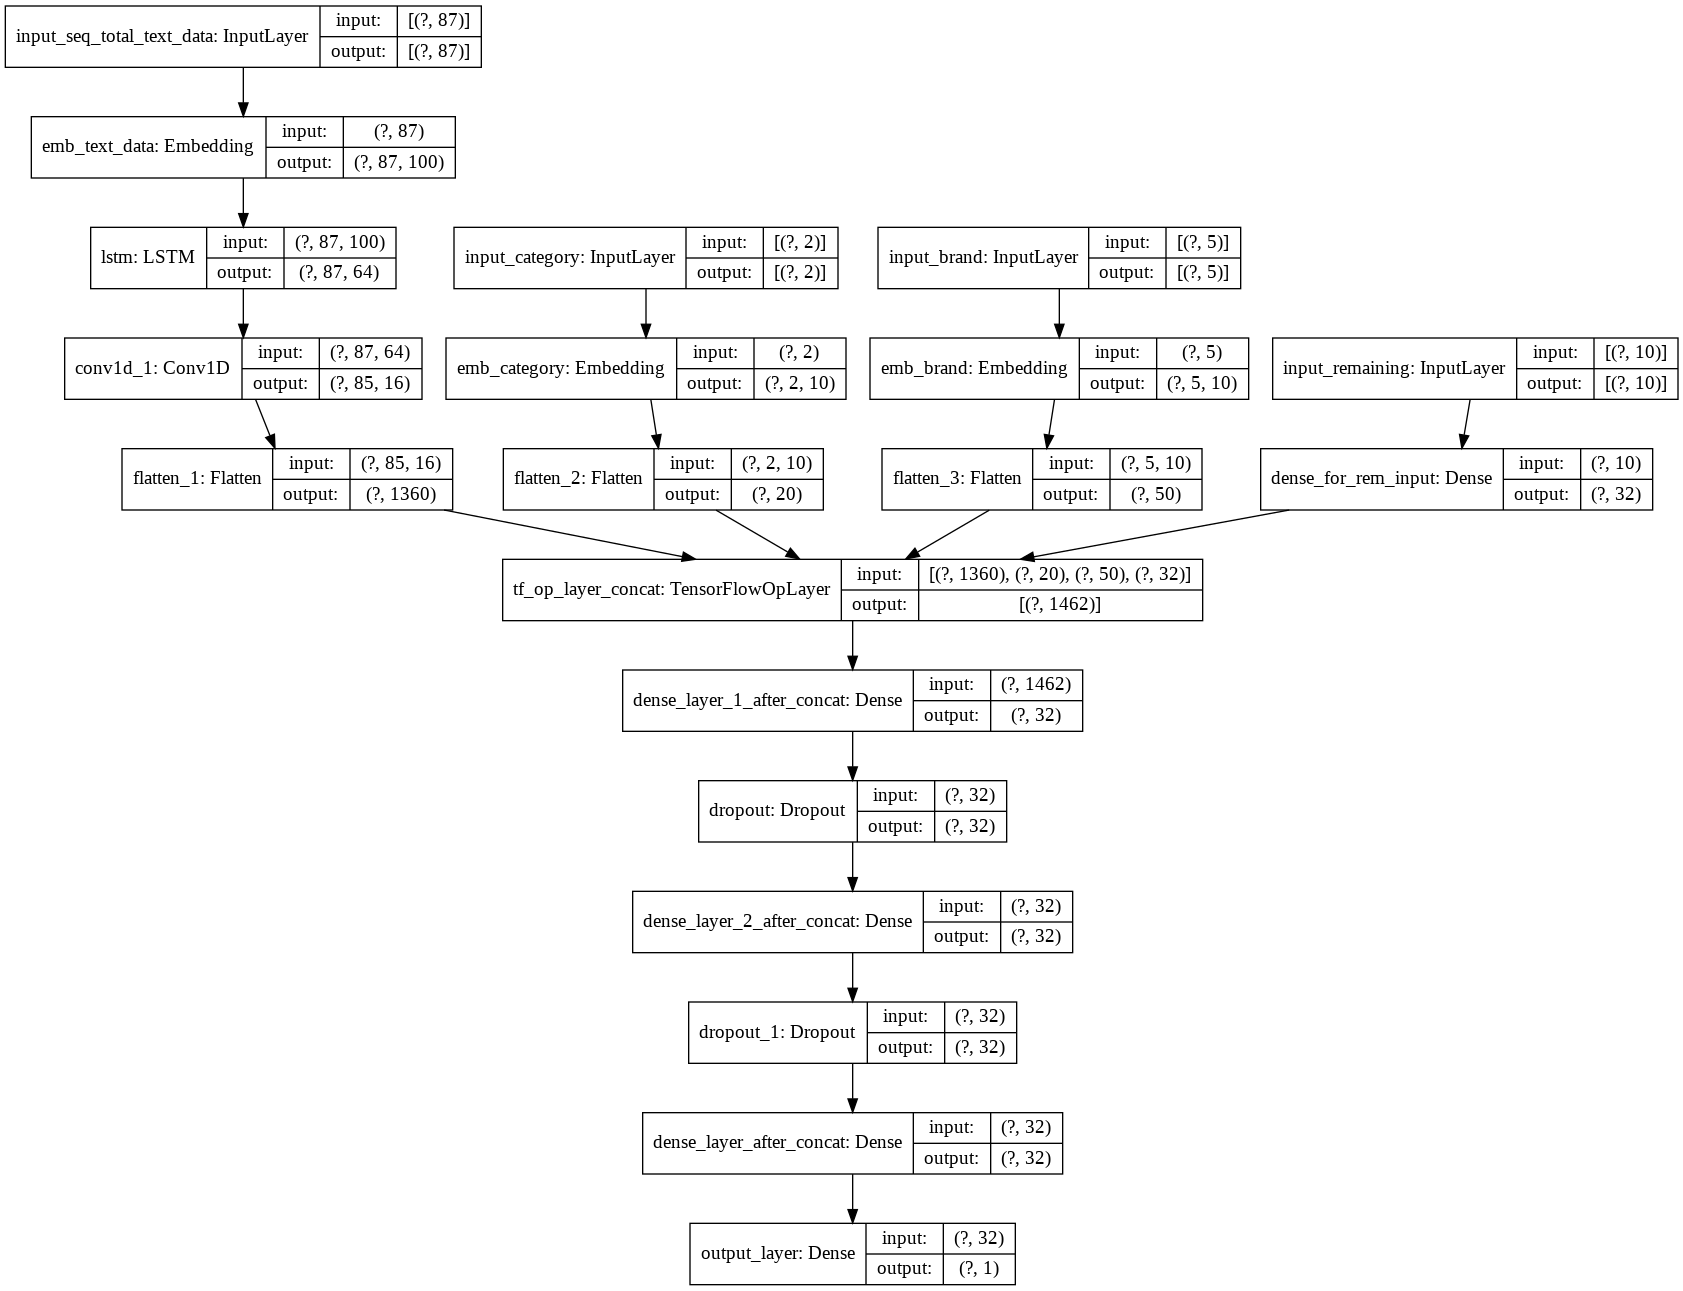

In [ ]:
plot_model(nn_model_1, show_shapes=True, to_file='nn_model_1.png')

In [ ]:
X_train_list = [X_train_essay_seq, X_train_category_seq, X_train_brand_seq, X_train_numeric]
X_test_list = [X_test_essay_seq, X_test_category_seq, X_test_brand_seq, X_test_numeric]

In [ ]:
filepath = "lstm_cnn_model_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, verbose=1)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

In [ ]:
callback_list = [checkpoint, early_stopping]

In [ ]:
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

In [ ]:
with tf.device('/device:GPU:0'):
  nn_model_1.fit(X_train_list, y_train_array, batch_size=512, epochs=30, validation_data=(X_test_list, y_test_array), callbacks=callback_list)

Epoch 1/30
2027/2027 [==============================] - ETA: 0s - loss: 4.7251
Epoch 00001: val_loss improved from inf to 0.93182, saving model to lstm_cnn_model_epochs:001-val_loss:0.932.hdf5
2027/2027 [==============================] - 416s 205ms/step - loss: 4.7251 - val_loss: 0.9318
Epoch 2/30
2027/2027 [==============================] - ETA: 0s - loss: 1.1682
Epoch 00002: val_loss improved from 0.93182 to 0.58807, saving model to lstm_cnn_model_epochs:002-val_loss:0.588.hdf5
2027/2027 [==============================] - 422s 208ms/step - loss: 1.1682 - val_loss: 0.5881
Epoch 3/30
2027/2027 [==============================] - ETA: 0s - loss: 0.5943
Epoch 00003: val_loss improved from 0.58807 to 0.56009, saving model to lstm_cnn_model_epochs:003-val_loss:0.560.hdf5
2027/2027 [==============================] - 421s 208ms/step - loss: 0.5943 - val_loss: 0.5601
Epoch 4/30
2027/2027 [==============================] - ETA: 0s - loss: 0.5287
Epoch 00004: val_loss improved from 0.56009 to 0.

In [ ]:
y_pred = nn_model_1.predict(X_test_list)
rmsle = np.sqrt(mean_squared_error(y_test_array, y_pred))

In [ ]:
print("RMSLE: ", rmsle)

RMSLE:  0.6997435799359837


### Ridge Regression

In [ ]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
model_list = []
rmsle_list = []
for i in alpha:
  ridge_reg = Ridge(alpha=i)
  ridge_reg.fit(X_train_merged_tfidf, y_train)
  y_pred = ridge_reg.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(ridge_reg)
  rmsle_list.append(rmsle)
  print("alpha: ", i, "; rmsle: ", rmsle)

alpha:  0.0001 ; rmsle:  0.47974959217876806
alpha:  0.001 ; rmsle:  0.4797489013525081
alpha:  0.01 ; rmsle:  0.4797488178278187
alpha:  0.1 ; rmsle:  0.4797400874197235
alpha:  1 ; rmsle:  0.47969922086157535
alpha:  10 ; rmsle:  0.47974688684454736
alpha:  100 ; rmsle:  0.48659892877235844
alpha:  1000 ; rmsle:  0.5260280891293256
alpha:  10000 ; rmsle:  0.6080889500865587


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Ridge Regression: ", rmsle_list[index])

RMSLE for Ridge Regression:  0.47969922086157535


In [ ]:
# best_model = model_list[index]
# pickle.dump((best_model), open('ridge_reg_model_tfidf.pkl', 'wb'))

### Stacking (Ensemble) Model

From the previous model-trainings, we have observed that the three most best peforming models are XGBoost, Ridge Regression and SVM. So, we shall be considering these three models as our Base-Models for buiding the stacking-ensemble model. As for the Meta-Model, we shall be considering a Linear Regression model

Here, instead of using the predefined stacking class from sklearn/mlextend library, we shall be implementing our own mechanism for the stacking-ensemble model.

#### Base Models

In [ ]:
xgboost_model_tfidf = pickle.load(open("xgboost_model_tfidf.pkl", 'rb'))
svm_model_tfidf = pickle.load(open("svm_model_tfidf.pkl", 'rb'))
ridge_reg_model_tfidf = pickle.load(open("ridge_reg_model_tfidf.pkl", 'rb'))

In [ ]:
y_pred_ridge = ridge_reg_model_tfidf.predict(X_train_merged_tfidf)
y_pred_xgboost = xgboost_model_tfidf.predict(X_train_merged_tfidf)
y_pred_svm = svm_model_tfidf.predict(X_train_merged_tfidf)

In [ ]:
print("y_pred_ridge: ", y_pred_ridge.shape)
print("y_pred_xgboost: ", y_pred_xgboost.reshape(-1, 1).shape)
print("y_pred_svm: ", y_pred_svm.reshape(-1, 1).shape)

y_pred_ridge:  (1037774, 1)
y_pred_xgboost:  (1037774, 1)
y_pred_svm:  (1037774, 1)


In [ ]:
y_pred_train = np.hstack((y_pred_ridge, y_pred_xgboost.reshape(-1, 1), y_pred_svm.reshape(-1, 1)))
print("y_pred_train: ", y_pred_train.shape)

y_pred_train:  (1037774, 3)


#### Meta Model

In [ ]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(y_pred_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
y_pred_ridge_test = ridge_reg_model_tfidf.predict(X_test_merged_tfidf)
y_pred_xgboost_test = xgboost_model_tfidf.predict(X_test_merged_tfidf)
y_pred_svm_test = svm_model_tfidf.predict(X_test_merged_tfidf)

In [ ]:
print("y_pred_ridge_test: ", y_pred_ridge_test.shape)
print("y_pred_xgboost_test: ", y_pred_xgboost_test.reshape(-1, 1).shape)
print("y_pred_svm_test: ", y_pred_svm_test.reshape(-1, 1).shape)

y_pred_ridge_test:  (444761, 1)
y_pred_xgboost_test:  (444761, 1)
y_pred_svm_test:  (444761, 1)


In [ ]:
y_pred_test = np.hstack((y_pred_ridge_test, y_pred_xgboost_test.reshape(-1, 1), y_pred_svm_test.reshape(-1, 1)))
print("y_pred_test: ", y_pred_test.shape)

y_pred_test:  (444761, 3)


In [ ]:
y_pred = linear_reg.predict(y_pred_test)
rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSLE for the Stacking (Ensemble) Model: ", rmsle)

RMSLE for the Stacking (Ensemble) Model:  0.46976319436101


In [ ]:
# pickle.dump((linear_reg), open('stacking_model_tfidf.pkl', 'wb'))

## Model Summary

| Model | RMSLE (Test Dataset) |
|------|--------|
|Linear Regression (W2V) | 107623308630.36296 |
|Linear Regression (TF-IDF) | 0.4991097776348212 |
|SVM (W2V) | 0.738126529776633 |
|SVM (TF-IDF) | 0.49861784388924685 |
|XGBoost (W2V) |0.5447924928285303 |
|XGBoost (TF-IDF) |0.46478922048855653 |
|Random Forest (W2V) | 0.5920548346130637 |
|Random Forest (TF-IDF) | 0.5877020211555425 |
|Decision Tree (W2V) | 0.6614672874557554 |
|Decision Tree (TF-IDF) | 0.6456642259530098 |
|LSTM+CNN |  0.6997435799359837 |
|Ridge Regression (TF-IDF) |  0.47969922086157535 |
|Stacking (TF-IDF) |  0.46976319436101 |

**NOTE:** Here we observe that the XGBoost model with TF-IDF vectorization for item_description feature gives the best RMSLE value of 0.46478922048855653

## Kaggle Prediction

### Sample Submission

In [ ]:
df = pd.read_csv('sample_submission.csv')
df.head()

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738
3,3,26.738
4,4,26.738


### Load the Test Data

In [ ]:
df = pd.read_csv('test_stg2.tsv', delimiter='\t')
df.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3460725 entries, 0 to 3460724
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   test_id            int64 
 1   name               object
 2   item_condition_id  int64 
 3   category_name      object
 4   brand_name         object
 5   shipping           int64 
 6   item_description   object
dtypes: int64(3), object(4)
memory usage: 184.8+ MB


### Text Preprocessing

In [ ]:
df.isnull().sum()

test_id                    0
name                       0
item_condition_id          0
category_name          14833
brand_name           1476490
shipping                   0
item_description           6
dtype: int64

In [ ]:
df['category_name'].fillna(value='Missing', inplace=True)
df['brand_name'].fillna(value='Missing', inplace=True)
df['item_description'].fillna(value='Missing', inplace=True)

In [ ]:
brand_dict = dict(df['brand_name'].value_counts())

In [ ]:
brand_list = []
for key, value in brand_dict.items():
  if value < 20:
    brand_list.append(key)  

In [ ]:
df['brand_name'] = df['brand_name'].progress_apply(lambda x : replace_brand(x, brand_list))

In [ ]:
df['brand_name'] = df['brand_name'].progress_apply(lambda x : replace_missing(x))

In [ ]:
df['main_categ'], _, _ = zip(*df['category_name'].progress_apply(lambda x : categ_split(x)))

In [ ]:
df.drop(columns='category_name', axis=1, inplace=True)

In [ ]:
df['main_categ'] = df['main_categ'].progress_apply(lambda x : replace_missing(x))

In [ ]:
df['ss_pos'], df['ss_neg'], df['ss_neu'], df['ss_com'] = zip(*df['item_description'].progress_apply(lambda x : 
                                                                                                    compute_sentiments(x, analyzer)))

In [ ]:
df['item_desc_preprocess'] = df['item_description'].progress_apply(lambda x : text_preprocess(x, eng_stopwords))

In [ ]:
df.drop(columns='item_description', axis=1, inplace=True)

In [ ]:
df['name_preprocess'] = df['name'].progress_apply(lambda x : text_preprocess(x, eng_stopwords))

In [ ]:
df.drop(columns='name', axis=1, inplace=True)

In [ ]:
df['item_desc_length'] = df['item_desc_preprocess'].progress_apply(lambda x : text_length(x))

In [ ]:
null_dataset = df[['item_condition_id', 'shipping', 'ss_pos', 'ss_neg', 'ss_neu', 'ss_com', 'item_desc_length', 'main_categ']]
notnull_dataset = null_dataset.dropna()

X_train = notnull_dataset.iloc[:, :-1]
y_train = notnull_dataset.iloc[:, -1]

In [ ]:
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)

In [ ]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, y_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
X_test = null_dataset.iloc[:, :-1]
y_test_label = pd.Series(model.predict(X_test))

In [ ]:
y_test_label_inv = pd.Series(label_encoder.inverse_transform(y_test_label))

In [ ]:
df['category'] = df['main_categ'].fillna(y_test_label_inv) 

In [ ]:
null_dataset = df[['item_condition_id', 'shipping', 'ss_pos', 'ss_neg', 'ss_neu', 'ss_com', 'item_desc_length', 'brand_name']]
notnull_dataset = null_dataset.dropna()

X_train = notnull_dataset.iloc[:, :-1]
y_train = notnull_dataset.iloc[:, -1]

In [ ]:
label_encoder = LabelEncoder()
y_train_label = label_encoder.fit_transform(y_train)

In [ ]:
model = KNeighborsClassifier(n_jobs=-1)
model.fit(X_train, y_train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
X_test = null_dataset.iloc[:, :-1]
y_test_label = pd.Series(model.predict(X_test))

In [ ]:
y_test_label_inv = pd.Series(label_encoder.inverse_transform(y_test_label))

In [ ]:
df['brand'] = df['brand_name'].fillna(y_test_label_inv) 

In [ ]:
df.drop(columns=['main_categ', 'brand_name'], axis=1, inplace=True)
df.head()

,test_id,item_condition_id,shipping,ss_pos,ss_neg,ss_neu,ss_com,item_desc_preprocess,name_preprocess,item_desc_length,category,brand
0,0,1,1,0.000,0.000,1.000,0.0000,size 7,breast cancer fight like girl ring,2,Women,Apple
1,1,1,1,0.244,0.000,0.756,0.8750,25 pcs new 7 5 x12 kraft bubble mailers lined ...,25 pcs new 7 5 x12 kraft bubble mailers,34,Other,Michael Kors
2,2,1,1,0.000,0.000,1.000,0.0000,brand new coach bag bought rm coach outlet,coach bag,8,Vintage & Collectibles,Coach
3,3,2,0,0.411,0.000,0.589,0.6796,floral kimono never worn lightweight perfect h...,floral kimono,8,Women,American Apparel
4,4,3,1,0.455,0.158,0.387,0.9622,rediscovering life loss loved one tony cooke p...,life death,21,Other,American Eagle


In [ ]:
df.to_csv('test_preprocess_stg2.csv', index=False)

### Feature Transformation

In [ ]:
df_train = pd.read_csv('train_preprocess.csv')
df_test = pd.read_csv('test_preprocess_stg2.csv')
df_train = df_train.replace(np.nan, '', regex=True)
df_test = df_test.replace(np.nan, '', regex=True)

In [ ]:
X = df_train[['item_condition_id', 'shipping', 'ss_pos', 'ss_neg', 'ss_neu', 'ss_com', 'item_desc_preprocess', 'name_preprocess', 
        'item_desc_length', 'category', 'brand']]
y = df_train[['price']]

In [ ]:
df_train, _, _, _ = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
minmax_scaler = MinMaxScaler().fit(df_train['item_desc_length'].values.reshape(-1,1))
item_desc_length = minmax_scaler.transform(df_test['item_desc_length'].values.reshape(-1,1))

In [ ]:
print("item_desc_length: ", item_desc_length.shape)

item_desc_length:  (3460725, 1)


In [ ]:
minmax_scaler = MinMaxScaler().fit(df_train['ss_pos'].values.reshape(-1,1))
ss_pos = minmax_scaler.transform(df_test['ss_pos'].values.reshape(-1,1))

In [ ]:
print("ss_pos: ", ss_pos.shape)

ss_pos:  (3460725, 1)


In [ ]:
minmax_scaler = MinMaxScaler().fit(df_train['ss_neg'].values.reshape(-1,1))
ss_neg = minmax_scaler.transform(df_test['ss_neg'].values.reshape(-1,1))

In [ ]:
print("ss_neg: ", ss_neg.shape)

ss_neg:  (3460725, 1)


In [ ]:
minmax_scaler = MinMaxScaler().fit(df_train['ss_neu'].values.reshape(-1,1))
ss_neu = minmax_scaler.transform(df_test['ss_neu'].values.reshape(-1,1))

In [ ]:
print("ss_neu: ", ss_neu.shape)

ss_neu:  (3460725, 1)


In [ ]:
minmax_scaler = MinMaxScaler().fit(df_train['ss_com'].values.reshape(-1,1))
ss_com = minmax_scaler.transform(df_test['ss_com'].values.reshape(-1,1))

In [ ]:
print("ss_com: ", ss_com.shape)

ss_com:  (3460725, 1)


In [ ]:
encoder = OneHotEncoder(drop='first').fit(df_train['item_condition_id'].values.reshape(-1,1))
item_condition = encoder.transform(df_test['item_condition_id'].values.reshape(-1,1))

In [ ]:
print("item_condition: ", item_condition.shape)

item_condition:  (3460725, 4)


In [ ]:
encoder = OneHotEncoder(drop='first').fit(df_train['shipping'].values.reshape(-1,1))
shipping = encoder.transform(df_test['shipping'].values.reshape(-1,1))

In [ ]:
print("shipping: ", shipping.shape)

shipping:  (3460725, 1)


In [ ]:
encoder = OneHotEncoder(drop='first').fit(df_train['category'].values.reshape(-1,1))
category = encoder.transform(df_test['category'].values.reshape(-1,1))

In [ ]:
print("category: ", category.shape)

category:  (3460725, 9)


In [ ]:
encoder = CountVectorizer(max_features=1279).fit(df_train['brand'].values)
brand = encoder.transform(df_test['brand'].values)

In [ ]:
print("brand: ", brand.shape)

brand:  (3460725, 1279)


In [ ]:
vectorizer = CountVectorizer(min_df=10, max_features=5000).fit(df_train['name_preprocess'].values)
name = vectorizer.transform(df_test['name_preprocess'].values)

In [ ]:
print("name: ", name.shape)

name:  (3460725, 5000)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=10, max_features=5000).fit(df_train['item_desc_preprocess'].values)
item_desc_tfidf = vectorizer.transform(df_test['item_desc_preprocess'].values)

In [ ]:
print("item_desc_tfidf: ", item_desc_tfidf.shape)

item_desc_tfidf:  (3460725, 5000)


### Feature Merging

In [ ]:
feature_merged_tfidf = hstack((item_desc_length, ss_pos, ss_neg, ss_neu, ss_com, 
                         item_condition, shipping, category, brand, name, 
                         item_desc_tfidf)).tocsr()

In [ ]:
print("feature_merged_tfidf: ", feature_merged_tfidf.shape)

feature_merged_tfidf:  (3460725, 11298)


In [ ]:
# pickle.dump((feature_merged_tfidf),open('kaggle_test_data_stg2_tfidf.pkl','wb'))

In [ ]:
feature_merged_tfidf = pickle.load(open("kaggle_test_data_stg2_tfidf.pkl", 'rb'))

### Model Prediction

**NOTE:** Since we have observed that TF-IDF tends to perform better than Word2Vec for the item_description feature, so we shall be considering only the TF-IDF feature transformation

In [12]:
def predict_scores(model, feature_merged_tfidf, df_test):

  '''Function to generate the predicted scores'''

  y_pred = model.predict(feature_merged_tfidf)
  y_pred_antilog = pd.Series([np.exp(i) for i in y_pred])
  test_id = pd.Series(df_test['test_id'].values)
  df = pd.DataFrame({'test_id' : test_id, 'price' : y_pred_antilog})  
  return df

#### Linear Regression

In [ ]:
lin_reg_model = pickle.load(open("lin_reg_model_tfidf.pkl", 'rb'))
df = predict_scores(lin_reg_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,13.507785
1,1,11.930713
2,2,21.650691
3,3,17.173584
4,4,16.797746


In [ ]:
df.to_csv('lin_reg_prediction_stg2.csv', index=False)

#### SVM

In [ ]:
svm_model = pickle.load(open("svm_model_tfidf.pkl", 'rb'))
df = predict_scores(svm_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,12.402985
1,1,11.917492
2,2,21.596008
3,3,15.966549
4,4,16.889908


In [ ]:
df.to_csv('svm_prediction_stg2.csv', index=False)

#### XGBoost

In [ ]:
xgboost_tfidf_model = pickle.load(open("xgboost_model_tfidf.pkl", 'rb'))
df = predict_scores(xgboost_tfidf_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,13.506027
1,1,12.336043
2,2,15.597831
3,3,18.654495
4,4,17.286676


In [ ]:
df.to_csv('xgboost_prediction_stg2.csv', index=False)

#### Random Forest

In [ ]:
rf_tfidf_model = pickle.load(open("random_forest_model_tfidf.pkl", 'rb'))
df = predict_scores(rf_tfidf_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,12.882958
1,1,12.583299
2,2,12.502904
3,3,19.007957
4,4,12.351142


In [ ]:
df.to_csv('random_forest_prediction_stg2.csv', index=False)

#### Decision Tree

In [ ]:
dt_tfidf_model = pickle.load(open("decision_tree_model_tfidf.pkl", 'rb'))
df = predict_scores(dt_tfidf_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,14.907325
1,1,13.197040
2,2,11.638171
3,3,19.595225
4,4,13.197040


In [ ]:
df.to_csv('decision_tree_prediction_stg2.csv', index=False)

#### LSTM+CNN

##### Item Description

In [ ]:
vectorizer = TfidfVectorizer(min_df=1)
X_train_essay_vect = vectorizer.fit_transform(df_train['item_desc_preprocess'])
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))

In [ ]:
print(np.percentile(idf, np.arange(0, 100, 25)))

[ 2.17110916 12.90667941 14.15944238 14.15944238]


In [ ]:
percentile_25 = 12.90667941
percentile_75 = 14.15944238
print("25th Percentile: ", percentile_25)
print("75th Percentile: ", percentile_75)

25th Percentile:  12.90667941
75th Percentile:  14.15944238


In [ ]:
X_train_essay_tfidf = []
for key in tqdm_notebook(idf_dict):
  value = idf_dict.get(key)
  if value>=percentile_25 and value<=percentile_75:
    X_train_essay_tfidf.append(key)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_essay_tfidf)
# X_train_sequences = tokenizer.texts_to_sequences(X_train_essay)
X_test_sequences = tokenizer.texts_to_sequences(df_test['item_desc_preprocess'])

In [ ]:
X_test_essay_seq = pad_sequences(X_test_sequences, maxlen=87)

In [ ]:
print("X_test_essay_seq: ", X_test_essay_seq.shape)

X_test_essay_seq:  (3460725, 87)


##### Category

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['category'])
# X_train_sequences = tokenizer.texts_to_sequences(X_train_cat)
X_test_sequences = tokenizer.texts_to_sequences(df_test['category'])

In [ ]:
X_test_category_seq = pad_sequences(X_test_sequences, maxlen=2)

In [ ]:
print(X_test_category_seq.shape)

(3460725, 2)


##### Brand

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['brand'])
# X_train_sequences = tokenizer.texts_to_sequences(X_train_cat)
X_test_sequences = tokenizer.texts_to_sequences(df_test['brand'])

In [ ]:
X_test_brand_seq = pad_sequences(X_test_sequences, maxlen=5)

In [ ]:
print(X_test_brand_seq.shape)

(3460725, 5)


##### Numerical

In [ ]:
item_condition = np.array(pd.get_dummies(df_test['item_condition_id'], drop_first=True))

In [ ]:
print(item_condition.shape)

(3460725, 4)


In [ ]:
shipping = np.array(pd.get_dummies(df_test['shipping'], drop_first=True))

In [ ]:
print(shipping.shape)

(3460725, 1)


In [ ]:
X_test_numeric = np.hstack((item_desc_length, ss_pos, ss_neg, ss_neu, ss_com, item_condition, shipping))

##### Prediction

In [ ]:
X_test_list = [X_test_essay_seq, X_test_category_seq, X_test_brand_seq, X_test_numeric]

In [ ]:
model = load_model('lstm_cnn_model_epochs_005-val_loss_0.473.hdf5')

In [ ]:
df = predict_scores(model, X_test_list, df_test)
df.head()

,test_id,price
0,0,[19.876696]
1,1,[23.034563]
2,2,[23.034563]
3,3,[21.346857]
4,4,[16.262218]


In [ ]:
df['price'] = df['price'].progress_apply(lambda x : x[0])

In [ ]:
df.head()

,test_id,price
0,0,19.876696
1,1,23.034563
2,2,23.034563
3,3,21.346857
4,4,16.262218


In [ ]:
df.to_csv('lstm_cnn_prediction_stg2.csv', index=False)

#### Ridge Regression

In [ ]:
ridge_reg_model = pickle.load(open("ridge_reg_model_tfidf.pkl", 'rb'))
df = predict_scores(ridge_reg_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,[13.22373689912181]
1,1,[8.12807306850739]
2,2,[19.66830230466679]
3,3,[13.062980295534075]
4,4,[20.429613323571022]


In [ ]:
df['price'] = df['price'].progress_apply(lambda x : x[0])
df.head()

,test_id,price
0,0,13.223737
1,1,8.128073
2,2,19.668302
3,3,13.062980
4,4,20.429613


In [ ]:
df.to_csv('ridge_reg_prediction_stg2.csv', index=False)

#### Stacking (Ensemble) Model

##### Base Models

In [ ]:
xgboost_model_tfidf = pickle.load(open("xgboost_model_tfidf.pkl", 'rb'))
svm_model_tfidf = pickle.load(open("svm_model_tfidf.pkl", 'rb'))
ridge_reg_model_tfidf = pickle.load(open("ridge_reg_model_tfidf.pkl", 'rb'))

In [ ]:
y_pred_ridge = ridge_reg_model_tfidf.predict(feature_merged_tfidf)
y_pred_xgboost = xgboost_model_tfidf.predict(feature_merged_tfidf)
y_pred_svm = svm_model_tfidf.predict(feature_merged_tfidf)

In [ ]:
print("y_pred_ridge: ", y_pred_ridge.shape)
print("y_pred_xgboost: ", y_pred_xgboost.reshape(-1, 1).shape)
print("y_pred_svm: ", y_pred_svm.reshape(-1, 1).shape)

y_pred_ridge:  (3460725, 1)
y_pred_xgboost:  (3460725, 1)
y_pred_svm:  (3460725, 1)


In [ ]:
y_pred_train = np.hstack((y_pred_ridge, y_pred_xgboost.reshape(-1, 1), y_pred_svm.reshape(-1, 1)))
print("y_pred_train: ", y_pred_train.shape)

y_pred_train:  (3460725, 3)


##### Meta Model

In [ ]:
stacking_model_tfidf = pickle.load(open("stacking_model_tfidf.pkl", 'rb'))
df = predict_scores(stacking_model_tfidf, y_pred_train, df_test)
df.head()

,test_id,price
0,0,[13.216338298008777]
1,1,[10.497654849910274]
2,2,[13.927705525660034]
3,3,[17.83638181448156]
4,4,[17.8346482279036]


In [ ]:
df['price'] = df['price'].progress_apply(lambda x : x[0])
df.head()

,test_id,price
0,0,13.216338
1,1,10.497655
2,2,13.927706
3,3,17.836382
4,4,17.834648


In [ ]:
df.to_csv('stacking_prediction_stg2.csv', index=False)

### Score Summary

Following is the list of scores as generated from the Kaggle kernels.

| Model | RMSLE (Kaggle) |
|------|--------|
|Linear Regression | 0.58976 |
|SVM | 0.59533 |
|XGBoost |0.61215 |
|Random Forest | 0.64071 |
|Decision Tree | 0.67937 |
|LSTM+CNN | 0.72225 |
|Ridge Regression | 0.68780 |
|Stacking (Ensemble) | 0.64167 |


Here we observe that our models have performed very poorly with the Kaggle dataset inspite of some of the models having relatively good scores with the Test Dataset.

As such we shall be modifying our original dataset with some new features in an attempt to generate better Kaggle scores

## NEW_Feature Engineering

In [ ]:
df_a = pd.read_csv('train.tsv', delimiter='\t')
df_a.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
df_b = pd.read_csv('train_preprocess.csv')
df_b = df_b.replace(np.nan, '', regex=True)
df_b.head()

,item_condition_id,price,shipping,ss_pos,ss_neg,ss_neu,ss_com,item_desc_preprocess,name_preprocess,item_desc_length,category,brand
0,3,2.397895,1,0.000,0.524,0.476,-0.2960,description yet,mlb cincinnati reds shirt size xl,2,Men,Aeropostale
1,3,3.970292,0,0.247,0.000,0.753,0.8957,keyboard great condition works like came box p...,razer blackwidow chroma keyboard,18,Electronics,Razer
2,1,2.397895,1,0.171,0.000,0.829,0.6792,adorable top hint lace key hole back pale pink...,ava viv blouse,14,Women,Target
3,1,3.583519,1,0.157,0.000,0.843,0.6808,new tags leather horses retail rm stand foot h...,leather horse statues,18,Home,Acacia Swimwear
4,1,3.806662,0,0.000,0.000,1.000,0.0000,complete certificate authenticity,24k gold plated rose,3,Women,PINK


In [ ]:
no_desc_count = 0
no_desc_string = 'No description yet'
for index in tqdm_notebook(range(len(df_a['item_description']))):
  if str(df_a['item_description'].values[index]) in no_desc_string:
    no_desc_count += 1

print("Total number of items with no descriptions: ", no_desc_count)


Total number of items with no descriptions:  82517


In [ ]:
def text_length(text, no_desc_string):

  '''Function to compute the text length only for items with descriptions'''
  
  try:
    if text in no_desc_string:
      return 0
    else:
      return len(text.split())
  except:
    return 0

In [ ]:
df_b['item_desc_length'] = df_a['item_description'].progress_apply(lambda x : text_length(x, no_desc_string))

In [ ]:
df_b['name_length'] = df_a['name'].progress_apply(lambda x : text_length(x, no_desc_string))

In [ ]:
df_a['category_name'].fillna(value='missing', inplace=True)

In [ ]:
df_b['main_categ'], df_b['sub_categ_one'], df_b['sub_categ_two'] = zip(*df_a['category_name'].progress_apply(lambda x : categ_split(x)))

In [ ]:
df_b.drop(columns=['ss_pos', 'ss_neg', 'ss_neu', 'ss_com', 'category', 'brand'], axis=1, inplace=True)

In [ ]:
brand_set = set(df_a['brand_name'].values)
df_a['brand_name'].fillna(value='missing', inplace=True)

In [ ]:
pickle.dump((brand_set),open('brand_set.pkl','wb'))

In [ ]:
# https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
def missing_brand(features):

  '''Function to fill the missing brands with words from the name feature'''
  
  brand = features[0]
  name = features[1]
  if brand == 'missing':
    for word in name.split():
      if word in brand_set:
        return word
  if name in brand_set:
    return name
  return brand

In [ ]:
df_b['brand'] = df_a[['brand_name', 'name']].progress_apply(missing_brand, axis=1)

In [ ]:
missing_brand_name = len(df_a.loc[df_a['brand_name'] == 'missing'])
missing_brand = len(df_b.loc[df_b['brand'] == 'missing'])
print("Detected brand names: ", missing_brand_name-missing_brand)

Detected brand names:  128886


In [ ]:
df_a['item_description'].fillna(value='missing', inplace=True)
df_b['item_description'] = df_a['item_description'].replace(no_desc_string, 'missing')

In [ ]:
df_b.drop(columns='item_desc_preprocess', axis=1, inplace=True)

In [ ]:
df_b['item_desc_preprocess'] = df_b['item_description'].progress_apply(lambda x : text_preprocess(x, eng_stopwords))

In [ ]:
df_b.drop(columns='item_description', axis=1, inplace=True)

In [ ]:
df_b.head()

,item_condition_id,price,shipping,name_preprocess,item_desc_length,name_length,main_categ,sub_categ_one,sub_categ_two,brand,item_desc_preprocess
0,3,2.397895,1,mlb cincinnati reds shirt size xl,0,7,Men,Tops,T-shirts,MLB,missing
1,3,3.970292,0,razer blackwidow chroma keyboard,36,4,Electronics,Computers & Tablets,Components & Parts,Razer,keyboard great condition works like came box p...
2,1,2.397895,1,ava viv blouse,29,2,Women,Tops & Blouses,Blouse,Target,adorable top hint lace key hole back pale pink...
3,1,3.583519,1,leather horse statues,32,3,Home,Home Décor,Home Décor Accents,missing,new tags leather horses retail rm stand foot h...
4,1,3.806662,0,24k gold plated rose,5,4,Women,Jewelry,Necklaces,missing,complete certificate authenticity


In [ ]:
df_b.isnull().any()

item_condition_id       False
price                   False
shipping                False
name_preprocess         False
item_desc_length        False
name_length             False
main_categ              False
sub_categ_one           False
sub_categ_two           False
brand                   False
item_desc_preprocess    False
dtype: bool

In [ ]:
# df_b.to_csv('train_preprocess_modif.csv', index=False)

In [ ]:
df = pd.read_csv('train_preprocess_modif.csv')
df = df.replace(np.nan, '', regex=True)

**FEATURE SUMMARY:**
*   We have added an additional **name_length** feature similar to the **item_desc_length** feature
*   As opposed to the previous dataset, here we are considering all the three divisions of categories as **main_categ**, **sub_categ_one** and **sub_categ_two**
*   For the sentiment scores, we observe that each of **ss_pos**, **ss_neg**, **ss_neu** and **ss_com** has correlation values of -0.021, -0.022, 0.035 and 0.002 respetively with respect to **price**. So we decided to drop these features from our dataset since none of them have a correlation value greater than 0.5
*   In case of **brand**, we observe a lot of missing values and so we tried to check the **name** feature for any possiblity of finding the missing values. With this technique, we were able to fill 128,886 missing brand values. As for the remaining, we marked it as '*missing*'
*   Also we were able to detect 82,517 cells marked as '*No description yet*' in the **item_description** column and so we replaced those cells along with the missing values by marking them as '*missing*'
*   As for the missing values in case of **category** column, we simply marked them as '*missing*'

## NEW_Splitting the Dataset

In [ ]:
X = df[['item_condition_id', 'shipping', 'name_preprocess', 'item_desc_length', 'name_length', 'main_categ', 'sub_categ_one', 
        'sub_categ_two', 'brand', 'item_desc_preprocess']]
y = df[['price']]

In [ ]:
print("X.shape: ", X.shape)
print("y.shape: ", y.shape)

X.shape:  (1482535, 10)
y.shape:  (1482535, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (1186028, 10)
y_train.shape:  (1186028, 1)
X_test.shape:  (296507, 10)
y_test.shape:  (296507, 1)


## NEW_Feature Transformation

In [ ]:
vectorizer = OneHotEncoder()
X_train_item_condition = vectorizer.fit_transform(X_train['item_condition_id'].values.reshape(-1,1))
X_test_item_condition = vectorizer.transform(X_test['item_condition_id'].values.reshape(-1,1))

In [ ]:
print("X_train_item_condition: ", X_train_item_condition.shape)
print("X_test_item_condition: ", X_test_item_condition.shape)

X_train_item_condition:  (1186028, 5)
X_test_item_condition:  (296507, 5)


In [ ]:
vectorizer = OneHotEncoder()
X_train_shipping = vectorizer.fit_transform(X_train['shipping'].values.reshape(-1,1))
X_test_shipping = vectorizer.transform(X_test['shipping'].values.reshape(-1,1))

In [ ]:
print("X_train_shipping: ", X_train_shipping.shape)
print("X_test_shipping: ", X_test_shipping.shape)

X_train_shipping:  (1186028, 2)
X_test_shipping:  (296507, 2)


In [ ]:
vectorizer = CountVectorizer()
X_train_main_categ = vectorizer.fit_transform(X_train['main_categ'].astype(str))
X_test_main_categ = vectorizer.transform(X_test['main_categ'].astype(str))

In [ ]:
print("X_train_main_categ: ", X_train_main_categ.shape)
print("X_test_main_categ: ", X_test_main_categ.shape)

X_train_main_categ:  (1186028, 13)
X_test_main_categ:  (296507, 13)


In [ ]:
vectorizer = CountVectorizer()
X_train_sub_categ_one = vectorizer.fit_transform(X_train['sub_categ_one'].astype(str))
X_test_sub_categ_one = vectorizer.transform(X_test['sub_categ_one'].astype(str))

In [ ]:
print("X_train_sub_categ_one: ", X_train_sub_categ_one.shape)
print("X_test_sub_categ_one: ", X_test_sub_categ_one.shape)

X_train_sub_categ_one:  (1186028, 142)
X_test_sub_categ_one:  (296507, 142)


In [ ]:
vectorizer = CountVectorizer()
X_train_sub_categ_two = vectorizer.fit_transform(X_train['sub_categ_two'].astype(str))
X_test_sub_categ_two = vectorizer.transform(X_test['sub_categ_two'].astype(str))

In [ ]:
print("X_train_sub_categ_two: ", X_train_sub_categ_two.shape)
print("X_test_sub_categ_two: ", X_test_sub_categ_two.shape)

X_train_sub_categ_two:  (1186028, 960)
X_test_sub_categ_two:  (296507, 960)


In [ ]:
vectorizer = CountVectorizer()
X_train_brand = vectorizer.fit_transform(X_train['brand'].astype(str))
X_test_brand = vectorizer.transform(X_test['brand'].astype(str))

In [ ]:
print("X_train_brand: ", X_train_brand.shape)
print("X_test_brand ", X_test_brand.shape)

X_train_brand:  (1186028, 4882)
X_test_brand  (296507, 4882)


In [ ]:
minmax_scaler = MinMaxScaler()
X_train_item_desc_length = minmax_scaler.fit_transform(X_train['item_desc_length'].values.reshape(-1,1))
X_test_item_desc_length = minmax_scaler.transform(X_test['item_desc_length'].values.reshape(-1,1))

In [ ]:
print("X_train_item_desc_length: ", X_train_item_desc_length.shape)
print("X_test_item_desc_length: ", X_test_item_desc_length.shape)

X_train_item_desc_length:  (1186028, 1)
X_test_item_desc_length:  (296507, 1)


In [ ]:
minmax_scaler = MinMaxScaler()
X_train_name_length = minmax_scaler.fit_transform(X_train['name_length'].values.reshape(-1,1))
X_test_name_length = minmax_scaler.transform(X_test['name_length'].values.reshape(-1,1))

In [ ]:
print("X_train_name_length: ", X_train_name_length.shape)
print("X_test_name_length: ", X_test_name_length.shape)

X_train_name_length:  (1186028, 1)
X_test_name_length:  (296507, 1)


In [ ]:
vectorizer = CountVectorizer(min_df=10, max_features=10000)
X_train_name = vectorizer.fit_transform(X_train['name_preprocess'].values)
X_test_name = vectorizer.transform(X_test['name_preprocess'].values)

In [ ]:
print("X_train_name: ", X_train_name.shape)
print("X_test_name: ", X_test_name.shape)

X_train_name:  (1186028, 10000)
X_test_name:  (296507, 10000)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=10, max_features=100000)
X_train_item_desc_tfidf = vectorizer.fit_transform(X_train['item_desc_preprocess'].values)
X_test_item_desc_tfidf = vectorizer.transform(X_test['item_desc_preprocess'].values)

In [ ]:
print("X_train_item_desc_tfidf: ", X_train_item_desc_tfidf.shape)
print("X_test_item_desc_tfidf: ", X_test_item_desc_tfidf.shape)

X_train_item_desc_tfidf:  (1186028, 100000)
X_test_item_desc_tfidf:  (296507, 100000)


### Saving the Fit-Transform Models

In [ ]:
df_train = pd.read_csv('train_preprocess_modif.csv')
df_train = df_train.replace(np.nan, '', regex=True)
X = df_train[['item_condition_id', 'shipping', 'name_preprocess', 'item_desc_length', 'name_length', 'main_categ', 'sub_categ_one', 
      'sub_categ_two', 'brand', 'item_desc_preprocess']]
y = df_train[['price']]
df_train, _, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)

item_cond_vectorizer = OneHotEncoder().fit(df_train['item_condition_id'].values.reshape(-1,1))
ship_vectorizer = OneHotEncoder().fit(df_train['shipping'].values.reshape(-1,1))
main_categ_vectorizer = CountVectorizer().fit(df_train['main_categ'].astype(str))
sub_categ_one_vectorizer = CountVectorizer().fit(df_train['sub_categ_one'].astype(str))
sub_categ_two_vectorizer = CountVectorizer().fit(df_train['sub_categ_two'].astype(str))
brand_vectorizer = CountVectorizer().fit(df_train['brand'].astype(str))
item_desc_length_minmax_scaler = MinMaxScaler().fit(df_train['item_desc_length'].values.reshape(-1,1))
name_length_minmax_scaler = MinMaxScaler().fit(df_train['name_length'].values.reshape(-1,1))
name_preprocess_vectorizer = CountVectorizer(min_df=10, max_features=10000).fit(df_train['name_preprocess'].values)
item_desc_preprocess_vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=10, 
                                                  max_features=100000).fit(df_train['item_desc_preprocess'].values)

pickle.dump((item_cond_vectorizer, ship_vectorizer, main_categ_vectorizer, sub_categ_one_vectorizer, 
             sub_categ_two_vectorizer, brand_vectorizer, item_desc_length_minmax_scaler, 
             name_length_minmax_scaler, name_preprocess_vectorizer, 
             item_desc_preprocess_vectorizer),open('train_fit_transform.pkl','wb'))

## NEW_Merging Features

In [ ]:
X_train_merged_tfidf = hstack((X_train_item_condition, X_train_shipping, X_train_main_categ, X_train_sub_categ_one, X_train_sub_categ_two, 
                         X_train_brand, X_train_item_desc_length, X_train_name_length, X_train_name, 
                         X_train_item_desc_tfidf)).tocsr()
X_test_merged_tfidf = hstack((X_test_item_condition, X_test_shipping, X_test_main_categ, X_test_sub_categ_one, X_test_sub_categ_two, 
                         X_test_brand, X_test_item_desc_length, X_test_name_length, X_test_name, 
                         X_test_item_desc_tfidf)).tocsr()

In [ ]:
print("X_train_merged_tfidf: ", X_train_merged_tfidf.shape)
print("y_train: ", y_train.shape)
print("X_test_merged_tfidf: ", X_test_merged_tfidf.shape)
print("y_test: ", y_test.shape)

X_train_merged_tfidf:  (1186028, 116006)
y_train:  (1186028, 1)
X_test_merged_tfidf:  (296507, 116006)
y_test:  (296507, 1)


In [ ]:
# pickle.dump((X_train_merged_tfidf, y_train, X_test_merged_tfidf, y_test),open('train_test_data_tfidf_modif.pkl','wb'))

In [22]:
X_train_merged_tfidf, y_train, X_test_merged_tfidf, y_test = pickle.load(open("train_test_data_tfidf_modif.pkl", 'rb'))
print("X_train_merged_tfidf: ", X_train_merged_tfidf.shape)
print("y_train: ", y_train.shape)
print("X_test_merged_tfidf: ", X_test_merged_tfidf.shape)
print("y_test: ", y_test.shape)

X_train_merged_tfidf:  (1186028, 116006)
y_train:  (1186028, 1)
X_test_merged_tfidf:  (296507, 116006)
y_test:  (296507, 1)


## NEW_Model Prediction

### Ridge Regression

In [ ]:
alpha = [0.1,1,10,100]
model_list = []
rmsle_list = []
for i in alpha:
  ridge_reg = Ridge(alpha=i)
  ridge_reg.fit(X_train_merged_tfidf, y_train)
  y_pred = ridge_reg.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(ridge_reg)
  rmsle_list.append(rmsle)
  print("alpha: ", i, "; rmsle: ", rmsle)

alpha:  0.1 ; rmsle:  0.47021107110770505
alpha:  1 ; rmsle:  0.46559165916707934
alpha:  10 ; rmsle:  0.46437452213973135
alpha:  100 ; rmsle:  0.48020948459778995


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for Ridge Regression: ", rmsle_list[index])

RMSLE for Ridge Regression:  0.46437452213973135


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('ridge_reg_model_tfidf_modif.pkl', 'wb'))

### SVM

In [ ]:
alpha = [1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09]
model_list = []
rmsle_list = []
for i in alpha:
  sgd_reg = SGDRegressor(loss='epsilon_insensitive', alpha=i)
  sgd_reg.fit(X_train_merged_tfidf, y_train)
  y_pred = sgd_reg.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(sgd_reg)
  rmsle_list.append(rmsle)
  print("alpha: ", i, "; rmsle: ", rmsle)

alpha:  0.001 ; rmsle:  0.5199529986992821
alpha:  0.0001 ; rmsle:  0.4937962693363712
alpha:  1e-05 ; rmsle:  0.4898455898214352
alpha:  1e-06 ; rmsle:  0.4885954400869422
alpha:  1e-07 ; rmsle:  0.48959313983049413
alpha:  1e-08 ; rmsle:  0.49024891391803854
alpha:  1e-09 ; rmsle:  0.48976901520306293


In [ ]:
index = np.argmin(rmsle_list)
print("RMSLE for SVM: ", rmsle_list[index])

RMSLE for SVM:  0.4885954400869422


In [ ]:
best_model = model_list[index]
pickle.dump((best_model), open('svm_model_tfidf_modif.pkl', 'wb'))

### XGBoost

In [6]:
n = 100000
indices = np.random.choice(X_train_merged_tfidf.shape[0], n, replace=False)
X_train_merged_tfidf_subset = X_train_merged_tfidf[indices]
y_train_subset = y_train.iloc[indices]

In [7]:
print("X_train_merged_tfidf_subset: ", X_train_merged_tfidf_subset.shape)
print("y_train_subset: ", y_train_subset.shape)

X_train_merged_tfidf_subset:  (100000, 116006)
y_train_subset:  (100000, 1)


In [8]:
n_estimators = [100, 200]
max_depth = [35, 55, 75]
model_list = []
rmsle_list = []
for i in n_estimators:
  for j in max_depth:
    #WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    start = timer()
    xgboost = XGBRegressor(max_depth=j, n_estimators=i, n_jobs=-1, objective='reg:squarederror')
    xgboost.fit(X_train_merged_tfidf_subset, y_train_subset)
    y_pred = xgboost.predict(X_test_merged_tfidf)
    rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
    model_list.append(xgboost)
    rmsle_list.append(rmsle)
    end = timer()
    time_min = np.round((end-start)/60)
    print("n_estimators: ", i, "; max_depth: ", j, "; rmsle: ", rmsle, "; duration: ", time_min, " minutes")
    
print("\n")
index = np.argmin(rmsle_list)
print("RMSLE for XGBRegressor: ", rmsle_list[index])
best_model = model_list[index]
pickle.dump((best_model), open('xgboost_model_tfidf_modif.pkl', 'wb'))

n_estimators:  100 ; max_depth:  35 ; rmsle:  0.5247220602282756 ; duration:  15.0  minutes
n_estimators:  100 ; max_depth:  55 ; rmsle:  0.5320952491403225 ; duration:  25.0  minutes
n_estimators:  100 ; max_depth:  75 ; rmsle:  0.5373016410989584 ; duration:  35.0  minutes
n_estimators:  200 ; max_depth:  35 ; rmsle:  0.51963380915358 ; duration:  26.0  minutes
n_estimators:  200 ; max_depth:  55 ; rmsle:  0.5290528676555729 ; duration:  42.0  minutes
n_estimators:  200 ; max_depth:  75 ; rmsle:  0.5350822715695888 ; duration:  56.0  minutes


RMSLE for XGBRegressor:  0.51963380915358


In [9]:
n_estimators = [300, 500]
max_depth = [25, 15, 5]
model_list = []
rmsle_list = []
for i in n_estimators:
  for j in max_depth:
    #WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    start = timer()
    xgboost = XGBRegressor(max_depth=j, n_estimators=i, n_jobs=-1, objective='reg:squarederror')
    xgboost.fit(X_train_merged_tfidf_subset, y_train_subset)
    y_pred = xgboost.predict(X_test_merged_tfidf)
    rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
    model_list.append(xgboost)
    rmsle_list.append(rmsle)
    end = timer()
    time_min = np.round((end-start)/60)
    print("n_estimators: ", i, "; max_depth: ", j, "; rmsle: ", rmsle, "; duration: ", time_min, " minutes")
    
print("\n")
index = np.argmin(rmsle_list)
print("RMSLE for XGBRegressor: ", rmsle_list[index])
best_model = model_list[index]
pickle.dump((best_model), open('xgboost_model_tfidf_modif.pkl', 'wb'))

n_estimators:  300 ; max_depth:  25 ; rmsle:  0.5129008855616497 ; duration:  24.0  minutes
n_estimators:  300 ; max_depth:  15 ; rmsle:  0.512525883598313 ; duration:  13.0  minutes
n_estimators:  300 ; max_depth:  5 ; rmsle:  0.5465466748138412 ; duration:  4.0  minutes
n_estimators:  500 ; max_depth:  25 ; rmsle:  0.5099050709824591 ; duration:  38.0  minutes
n_estimators:  500 ; max_depth:  15 ; rmsle:  0.5065580924203321 ; duration:  22.0  minutes
n_estimators:  500 ; max_depth:  5 ; rmsle:  0.5318901924898899 ; duration:  6.0  minutes


RMSLE for XGBRegressor:  0.5065580924203321


### LGBM

In [5]:
n_estimators = [100, 200]
max_depth = [35, 55, 75]
model_list = []
rmsle_list = []
for i in n_estimators:
  for j in max_depth:    
    start = timer()
    lgbm = LGBMRegressor(max_depth=j, n_estimators=i, n_jobs=-1)
    lgbm.fit(X_train_merged_tfidf, y_train)
    y_pred = lgbm.predict(X_test_merged_tfidf)
    rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
    model_list.append(lgbm)
    rmsle_list.append(rmsle)
    end = timer()
    time_min = np.round((end-start)/60)
    print("n_estimators: ", i, "; max_depth: ", j, "; rmsle: ", rmsle, "; duration: ", time_min, " minutes")
    
print("\n")
index = np.argmin(rmsle_list)
print("RMSLE for LGBMRegressor: ", rmsle_list[index])
best_model = model_list[index]
pickle.dump((best_model), open('lgbm_model_tfidf_modif.pkl', 'wb'))

n_estimators:  100 ; max_depth:  35 ; rmsle:  0.536398661000368 ; duration:  6.0  minutes
n_estimators:  100 ; max_depth:  55 ; rmsle:  0.536398661000368 ; duration:  6.0  minutes
n_estimators:  100 ; max_depth:  75 ; rmsle:  0.536398661000368 ; duration:  6.0  minutes
n_estimators:  200 ; max_depth:  35 ; rmsle:  0.5110833579457559 ; duration:  12.0  minutes
n_estimators:  200 ; max_depth:  55 ; rmsle:  0.5110833579457559 ; duration:  12.0  minutes
n_estimators:  200 ; max_depth:  75 ; rmsle:  0.5110833579457559 ; duration:  12.0  minutes


RMSLE for LGBMRegressor:  0.5110833579457559


In [7]:
n_estimators = [300, 500, 700, 1000]
model_list = []
rmsle_list = []
for i in n_estimators:    
  start = timer()
  lgbm = LGBMRegressor(max_depth=35, n_estimators=i, n_jobs=-1)
  lgbm.fit(X_train_merged_tfidf, y_train)
  y_pred = lgbm.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(lgbm)
  rmsle_list.append(rmsle)
  end = timer()
  time_min = np.round((end-start)/60)
  print("n_estimators: ", i, "; max_depth: ", 35, "; rmsle: ", rmsle, "; duration: ", time_min, " minutes")
    
print("\n")
index = np.argmin(rmsle_list)
print("RMSLE for LGBMRegressor: ", rmsle_list[index])
best_model = model_list[index]
pickle.dump((best_model), open('lgbm_model_tfidf_modif.pkl', 'wb'))

n_estimators:  300 ; max_depth:  35 ; rmsle:  0.49808000236776134 ; duration:  18.0  minutes
n_estimators:  500 ; max_depth:  35 ; rmsle:  0.48284563339665004 ; duration:  30.0  minutes
n_estimators:  700 ; max_depth:  35 ; rmsle:  0.4737562917064459 ; duration:  40.0  minutes
n_estimators:  1000 ; max_depth:  35 ; rmsle:  0.4650433848011329 ; duration:  56.0  minutes


RMSLE for LGBMRegressor:  0.4650433848011329


In [8]:
n_estimators = [2000, 5000]
model_list = []
rmsle_list = []
for i in n_estimators:    
  start = timer()
  lgbm = LGBMRegressor(max_depth=35, n_estimators=i, n_jobs=-1)
  lgbm.fit(X_train_merged_tfidf, y_train)
  y_pred = lgbm.predict(X_test_merged_tfidf)
  rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
  model_list.append(lgbm)
  rmsle_list.append(rmsle)
  end = timer()
  time_min = np.round((end-start)/60)
  print("n_estimators: ", i, "; max_depth: ", 35, "; rmsle: ", rmsle, "; duration: ", time_min, " minutes")
    
print("\n")
index = np.argmin(rmsle_list)
print("RMSLE for LGBMRegressor: ", rmsle_list[index])
best_model = model_list[index]
pickle.dump((best_model), open('lgbm_model_tfidf_modif.pkl', 'wb'))

n_estimators:  2000 ; max_depth:  35 ; rmsle:  0.4511922492324236 ; duration:  102.0  minutes
n_estimators:  5000 ; max_depth:  35 ; rmsle:  0.43800556635391735 ; duration:  213.0  minutes


RMSLE for LGBMRegressor:  0.43800556635391735


In [5]:
start = timer()
lgbm = LGBMRegressor(max_depth=35, n_estimators=10000, n_jobs=-1)
lgbm.fit(X_train_merged_tfidf, y_train)
y_pred = lgbm.predict(X_test_merged_tfidf)
rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
end = timer()
time_min = np.round((end-start)/60)
print("n_estimators: ", 10000, "; max_depth: ", 35, "; rmsle: ", rmsle, "; duration: ", time_min, " minutes")
pickle.dump((lgbm), open('lgbm_model_tfidf_modif.pkl', 'wb'))

n_estimators:  10000 ; max_depth:  35 ; rmsle:  0.43206819684050385 ; duration:  376.0  minutes


Here we shall be considering LGBM over XGBoost because LGBM itself uses XGBoost as a baseline model and is almost 7 times faster than XGBoost which is a much better approach when dealing with large datasets which holds true in our case with a dataset of shape (1186028, 116006)

### Stacking (Ensemble) Model

#### Base Models

In [18]:
lgbm_model_tfidf = pickle.load(open("lgbm_model_tfidf_modif_0_4320.pkl", 'rb'))
svm_model_tfidf = pickle.load(open("svm_model_tfidf_modif.pkl", 'rb'))
ridge_reg_model_tfidf = pickle.load(open("ridge_reg_model_tfidf_modif.pkl", 'rb'))

In [24]:
start = timer()
y_pred_ridge = ridge_reg_model_tfidf.predict(X_train_merged_tfidf)
y_pred_lgbm = lgbm_model_tfidf.predict(X_train_merged_tfidf)
y_pred_svm = svm_model_tfidf.predict(X_train_merged_tfidf)
end = timer()
duration = np.round((end-start)/60)
print("Time taken for prediction: ", duration, " minutes")

Time taken for prediction:  64.0  minutes


In [25]:
print("y_pred_ridge: ", y_pred_ridge.shape)
print("y_pred_lgbm: ", y_pred_lgbm.reshape(-1, 1).shape)
print("y_pred_svm: ", y_pred_svm.reshape(-1, 1).shape)

y_pred_ridge:  (1186028, 1)
y_pred_lgbm:  (1186028, 1)
y_pred_svm:  (1186028, 1)


In [26]:
y_pred_train = np.hstack((y_pred_ridge, y_pred_lgbm.reshape(-1, 1), y_pred_svm.reshape(-1, 1)))
print("y_pred_train: ", y_pred_train.shape)

y_pred_train:  (1186028, 3)


#### Meta Model

In [27]:
linear_reg = LinearRegression(n_jobs=-1)
linear_reg.fit(y_pred_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [29]:
start = timer()
y_pred_ridge_test = ridge_reg_model_tfidf.predict(X_test_merged_tfidf)
y_pred_lgbm_test = lgbm_model_tfidf.predict(X_test_merged_tfidf)
y_pred_svm_test = svm_model_tfidf.predict(X_test_merged_tfidf)
end = timer()
duration = np.round((end-start)/60)
print("Time taken for prediction: ", duration, " minutes")

Time taken for prediction:  16.0  minutes


In [30]:
print("y_pred_ridge_test: ", y_pred_ridge_test.shape)
print("y_pred_lgbm_test: ", y_pred_lgbm_test.reshape(-1, 1).shape)
print("y_pred_svm_test: ", y_pred_svm_test.reshape(-1, 1).shape)

y_pred_ridge_test:  (296507, 1)
y_pred_lgbm_test:  (296507, 1)
y_pred_svm_test:  (296507, 1)


In [31]:
y_pred_test = np.hstack((y_pred_ridge_test, y_pred_lgbm_test.reshape(-1, 1), y_pred_svm_test.reshape(-1, 1)))
print("y_pred_test: ", y_pred_test.shape)

y_pred_test:  (296507, 3)


In [32]:
y_pred = linear_reg.predict(y_pred_test)
rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSLE for the Stacking (Ensemble) Model: ", rmsle)

RMSLE for the Stacking (Ensemble) Model:  0.44062702537603204


In [33]:
# pickle.dump((linear_reg), open('stacking_model_tfidf_modif.pkl', 'wb'))

## NEW_Kaggle Prediction

### Text Preprocessing

In [ ]:
df = pd.read_csv('test_stg2.tsv', delimiter='\t')
df.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [ ]:
no_desc_count = 0
no_desc_string = 'No description yet'
for index in tqdm_notebook(range(len(df['item_description']))):
  if str(df['item_description'].values[index]) in no_desc_string:
    no_desc_count += 1

print("Total number of items with no descriptions: ", no_desc_count)


Total number of items with no descriptions:  193656


In [ ]:
df['item_desc_length'] = df['item_description'].progress_apply(lambda x : text_length(x, no_desc_string))

In [ ]:
df['name_length'] = df['name'].progress_apply(lambda x : text_length(x, no_desc_string))

In [ ]:
df['category_name'].fillna(value='missing', inplace=True)

In [ ]:
df['main_categ'], df['sub_categ_one'], df['sub_categ_two'] = zip(*df['category_name'].progress_apply(lambda x : categ_split(x)))

In [ ]:
brand_set = set(df['brand_name'].values)
df['brand_name'].fillna(value='missing', inplace=True)

In [ ]:
missing_brand_name = len(df.loc[df['brand_name'] == 'missing'])

In [ ]:
df['brand'] = df[['brand_name', 'name']].progress_apply(missing_brand, axis=1)

In [ ]:
missing_brand = len(df.loc[df['brand'] == 'missing'])
print("Detected brand names: ", missing_brand_name-missing_brand)

Detected brand names:  341389


In [ ]:
df['item_description'].fillna(value='missing', inplace=True)
df['item_description'] = df['item_description'].replace(no_desc_string, 'missing')

In [ ]:
df['item_desc_preprocess'] = df['item_description'].progress_apply(lambda x : text_preprocess(x, eng_stopwords))

In [ ]:
df['name_preprocess'] = df['name'].progress_apply(lambda x : text_preprocess(x, eng_stopwords))

In [ ]:
df.drop(columns=['name', 'category_name', 'brand_name', 'item_description'], axis=1, inplace=True)

In [ ]:
df.head()

,test_id,item_condition_id,shipping,item_desc_length,name_length,main_categ,sub_categ_one,sub_categ_two,brand,item_desc_preprocess,name_preprocess
0,0,1,1,2,8,Women,Jewelry,Rings,missing,size 7,breast cancer fight like girl ring
1,1,1,1,38,7,Other,Office supplies,Shipping Supplies,Kraft,25 pcs new 7 5 x12 kraft bubble mailers lined ...,25 pcs new 7 5 x12 kraft bubble mailers
2,2,1,1,11,2,Vintage & Collectibles,Bags and Purses,Handbag,Coach,brand new coach bag bought rm coach outlet,coach bag
3,3,2,0,10,2,Women,Sweaters,Cardigan,missing,floral kimono never worn lightweight perfect h...,floral kimono
4,4,3,1,29,3,Other,Books,Religion & Spirituality,missing,rediscovering life loss loved one tony cooke p...,life death


In [ ]:
df.to_csv('test_preprocess_stg2_modif.csv', index=False)

### Feature Transformation

In [10]:
df_train = pd.read_csv('train_preprocess_modif.csv')
df_test = pd.read_csv('test_preprocess_stg2_modif.csv')
df_train = df_train.replace(np.nan, '', regex=True)
df_test = df_test.replace(np.nan, '', regex=True)

In [ ]:
X = df_train[['item_condition_id', 'shipping', 'name_preprocess', 'item_desc_length', 'name_length', 'main_categ', 'sub_categ_one', 
        'sub_categ_two', 'brand', 'item_desc_preprocess']]
y = df_train[['price']]

In [ ]:
df_train, _, _, _ = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
vectorizer = OneHotEncoder().fit(df_train['item_condition_id'].values.reshape(-1,1))
item_condition = vectorizer.transform(df_test['item_condition_id'].values.reshape(-1,1))

In [ ]:
print("item_condition: ", item_condition.shape)

item_condition:  (3460725, 5)


In [ ]:
vectorizer = OneHotEncoder().fit(df_train['shipping'].values.reshape(-1,1))
shipping = vectorizer.transform(df_test['shipping'].values.reshape(-1,1))

In [ ]:
print("shipping: ", shipping.shape)

shipping:  (3460725, 2)


In [ ]:
vectorizer = CountVectorizer().fit(df_train['main_categ'].astype(str))
main_categ = vectorizer.transform(df_test['main_categ'].astype(str))

In [ ]:
print("main_categ: ", main_categ.shape)

main_categ:  (3460725, 13)


In [ ]:
vectorizer = CountVectorizer().fit(df_train['sub_categ_one'].astype(str))
sub_categ_one = vectorizer.transform(df_test['sub_categ_one'].astype(str))

In [ ]:
print("sub_categ_one: ", sub_categ_one.shape)

sub_categ_one:  (3460725, 142)


In [ ]:
vectorizer = CountVectorizer().fit(df_train['sub_categ_two'].astype(str))
sub_categ_two = vectorizer.transform(df_test['sub_categ_two'].astype(str))

In [ ]:
print("sub_categ_two: ", sub_categ_two.shape)

sub_categ_two:  (3460725, 960)


In [ ]:
vectorizer = CountVectorizer().fit(df_train['brand'].astype(str))
brand = vectorizer.transform(df_test['brand'].astype(str))

In [ ]:
print("brand: ", brand.shape)

brand:  (3460725, 4882)


In [ ]:
minmax_scaler = MinMaxScaler().fit(df_train['item_desc_length'].values.reshape(-1,1))
item_desc_length = minmax_scaler.transform(df_test['item_desc_length'].values.reshape(-1,1))

In [ ]:
print("item_desc_length: ", item_desc_length.shape)

item_desc_length:  (3460725, 1)


In [ ]:
minmax_scaler = MinMaxScaler().fit(df_train['name_length'].values.reshape(-1,1))
name_length = minmax_scaler.transform(df_test['name_length'].values.reshape(-1,1))

In [ ]:
print("name_length: ", name_length.shape)

name_length:  (3460725, 1)


In [ ]:
vectorizer = CountVectorizer(min_df=10, max_features=10000).fit(df_train['name_preprocess'].values)
name = vectorizer.transform(df_test['name_preprocess'].values)

In [ ]:
print("name: ", name.shape)

name:  (3460725, 10000)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=10, max_features=100000).fit(df_train['item_desc_preprocess'].values)
item_desc_tfidf = vectorizer.transform(df_test['item_desc_preprocess'].values)

In [ ]:
print("item_desc_tfidf: ", item_desc_tfidf.shape)

item_desc_tfidf:  (3460725, 100000)


### Feature Merging

In [ ]:
feature_merged_tfidf = hstack((item_condition, shipping, main_categ, sub_categ_one, sub_categ_two, 
                         brand, item_desc_length, name_length, name, 
                         item_desc_tfidf)).tocsr()

In [ ]:
print("feature_merged_tfidf: ", feature_merged_tfidf.shape)

feature_merged_tfidf:  (3460725, 116006)


In [ ]:
# pickle.dump((feature_merged_tfidf),open('kaggle_test_data_stg2_tfidf_modif.pkl','wb'))

In [6]:
feature_merged_tfidf = pickle.load(open("kaggle_test_data_stg2_tfidf_modif.pkl", 'rb'))

In [7]:
print("feature_merged_tfidf: ", feature_merged_tfidf.shape)

feature_merged_tfidf:  (3460725, 116006)


### Model Prediction

#### Ridge Regression

In [ ]:
ridge_reg_model = pickle.load(open("ridge_reg_model_tfidf_modif.pkl", 'rb'))
df = predict_scores(ridge_reg_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,[12.986412616452183]
1,1,[10.816692769718294]
2,2,[50.52225310770958]
3,3,[15.09717069920962]
4,4,[8.07622368068345]


In [ ]:
df['price'] = df['price'].progress_apply(lambda x : x[0])
df.head()

,test_id,price
0,0,12.986413
1,1,10.816693
2,2,50.522253
3,3,15.097171
4,4,8.076224


In [ ]:
df.to_csv('ridge_reg_prediction_stg2_modif.csv', index=False)

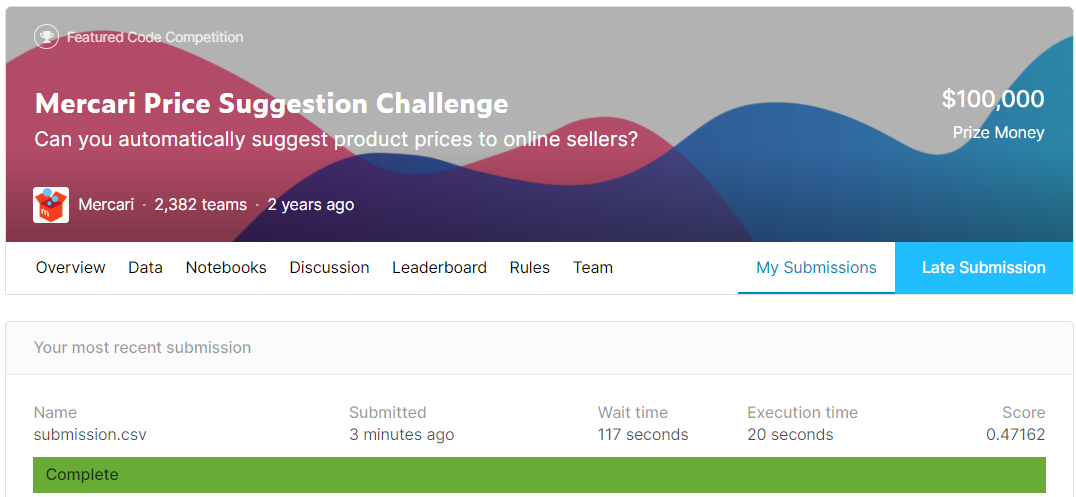

In [ ]:
Image("kaggle_score_ridge_reg_modif.png")

#### SVM

In [11]:
svm_model = pickle.load(open("svm_model_tfidf_modif.pkl", 'rb'))
df = predict_scores(svm_model, feature_merged_tfidf, df_test)
df.head()

,test_id,price
0,0,11.062506
1,1,12.488089
2,2,44.166788
3,3,16.127071
4,4,8.092540


In [12]:
df.to_csv('svm_prediction_stg2_modif.csv', index=False)

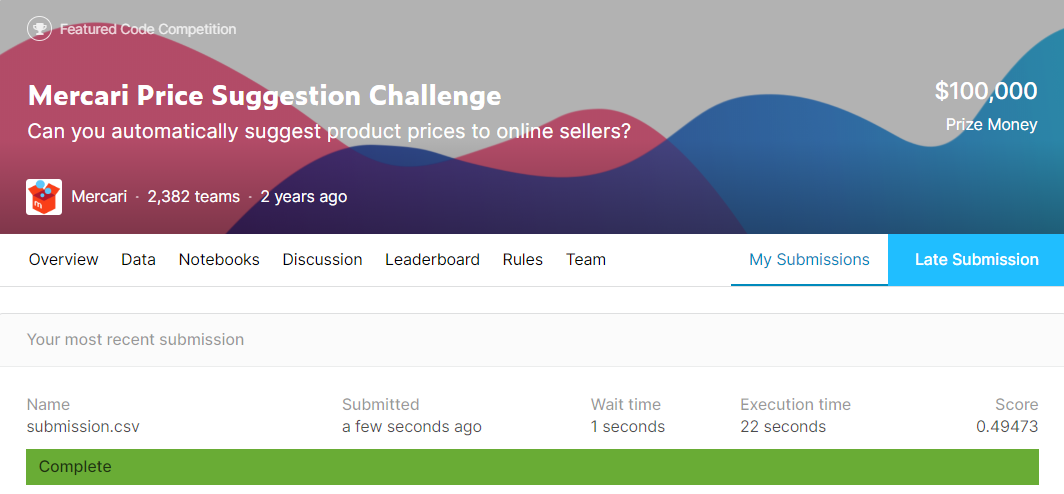

In [15]:
Image("kaggle_score_svm_modif.png")

#### LGBM

In [13]:
lgbm_model = pickle.load(open("lgbm_model_tfidf_modif_0_4320.pkl", 'rb'))
df = predict_scores(lgbm_model, feature_merged_tfidf, df_test)
df.to_csv('lgbm_prediction_stg2_modif.csv', index=False)
df.head()

,test_id,price
0,0,8.494871
1,1,11.432689
2,2,54.161641
3,3,14.975868
4,4,8.141414


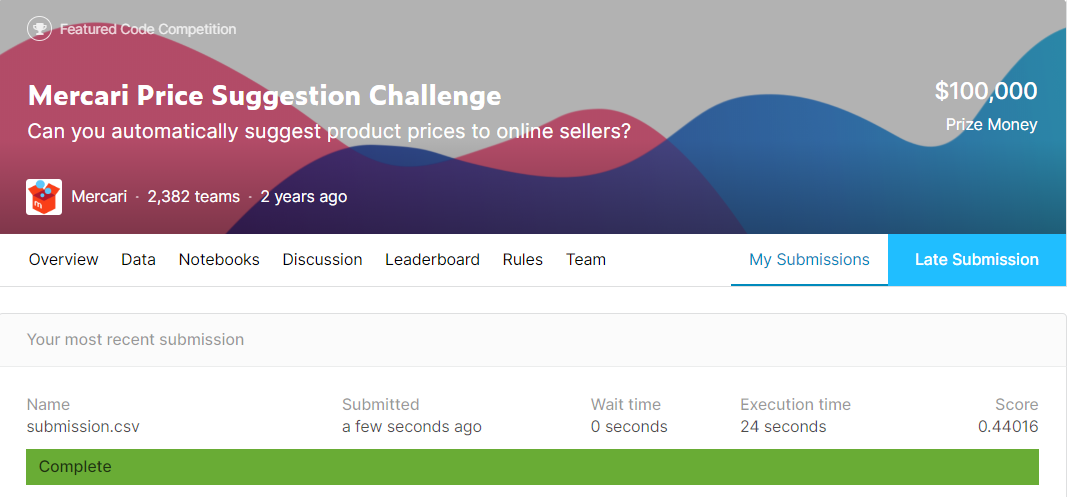

In [15]:
Image("kaggle_score_lgbm_modif.png")

#### Stacking (Ensemble) Model

##### Base Models

In [34]:
lgbm_model_tfidf = pickle.load(open("lgbm_model_tfidf_modif_0_4320.pkl", 'rb'))
svm_model_tfidf = pickle.load(open("svm_model_tfidf_modif.pkl", 'rb'))
ridge_reg_model_tfidf = pickle.load(open("ridge_reg_model_tfidf_modif.pkl", 'rb'))

In [36]:
start = timer()
y_pred_ridge = ridge_reg_model_tfidf.predict(feature_merged_tfidf)
y_pred_lgbm = lgbm_model_tfidf.predict(feature_merged_tfidf)
y_pred_svm = svm_model_tfidf.predict(feature_merged_tfidf)
end = timer()
duration = np.round((end-start)/60)
print("Time taken for prediction: ", duration, " minutes")

Time taken for prediction:  180.0  minutes


In [37]:
print("y_pred_ridge: ", y_pred_ridge.shape)
print("y_pred_lgbm: ", y_pred_lgbm.reshape(-1, 1).shape)
print("y_pred_svm: ", y_pred_svm.reshape(-1, 1).shape)

y_pred_ridge:  (3460725, 1)
y_pred_lgbm:  (3460725, 1)
y_pred_svm:  (3460725, 1)


In [38]:
y_pred_train = np.hstack((y_pred_ridge, y_pred_lgbm.reshape(-1, 1), y_pred_svm.reshape(-1, 1)))
print("y_pred_train: ", y_pred_train.shape)

y_pred_train:  (3460725, 3)


##### Meta Model

In [40]:
stacking_model_tfidf = pickle.load(open("stacking_model_tfidf_modif.pkl", 'rb'))
df = predict_scores(stacking_model_tfidf, y_pred_train, df_test)
df.head()

,test_id,price
0,0,[7.416480479042442]
1,1,[10.943112692322213]
2,2,[58.370717028310686]
3,3,[14.412561194674092]
4,4,[8.02599227914081]


In [41]:
df['price'] = df['price'].progress_apply(lambda x : x[0])
df.head()

,test_id,price
0,0,7.416480
1,1,10.943113
2,2,58.370717
3,3,14.412561
4,4,8.025992


In [42]:
df.to_csv('stacking_prediction_stg2_modif.csv', index=False)

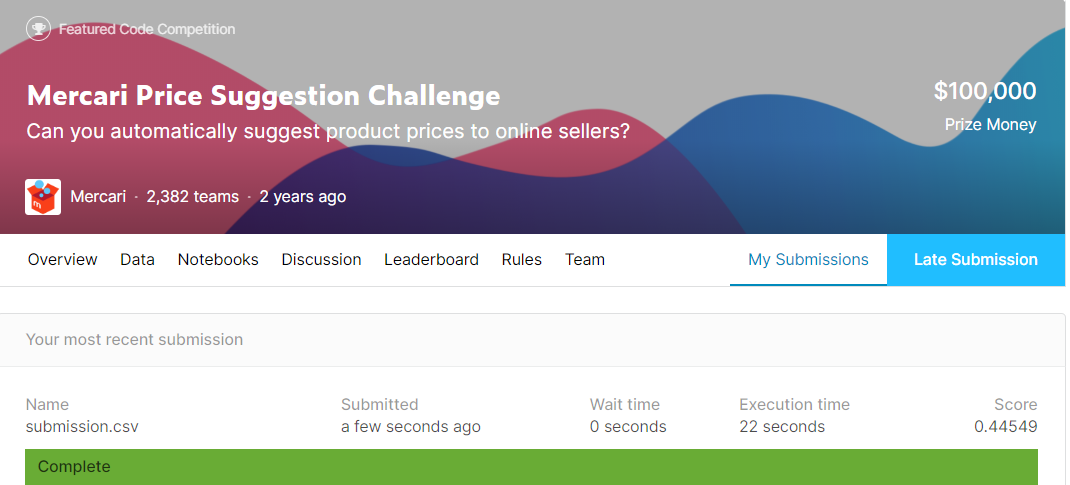

In [44]:
Image("kaggle_score_stacking_modif.png")

## NEW_Score Summary

As per the new techniques in feature engineering that we have implemented, following is the list of RMSLE values of the test dataset along with the respective Kaggle scores

| Model | RMSLE (Test Dataset) | RMSLE (Kaggle) |
|------|--------|--------|
|Ridge Regression | 0.46437 | 0.47162 |
|SVM | 0.48859 | 0.49473 |
|LGBM | 0.43206 | 0.44016 |
|Stacking (Ensemble) | 0.44062 | 0.44549 |


Here we observe that LGBM performs the best with an RMSLE value of 0.43206 on the Test Dataset and 0.44016 on the Kaggle kernel